# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

import os
import multiprocessing
# Ensure CPU cores are detected correctly
os.environ["LOKY_MAX_CPU_COUNT"] = str(multiprocessing.cpu_count())  # Dynamically set based on available cores
print("CPU: ", str(multiprocessing.cpu_count()))


CPU:  8


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [5]:
# Load the general demographics data
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Check the shape of the dataset
print("General Demographics Data Shape:", azdias.shape)

# Display the first few rows of the dataset
display(azdias.head())

General Demographics Data Shape: (891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
# Explore the demographics data
print(azdias.info())
display(azdias.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Load the feature summary file
feat_summary = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

# Function to convert missing value strings into a list of missing codes
def convert_missing_values(feat_info):
    # Ensure input is a string, remove brackets, and split by commas
    feat_info = str(feat_info).strip('[]')
    missing_values = [val.strip() for val in feat_info.split(',') if val]
    # Convert numerical values to integers where possible
    return [int(val) if val.lstrip('-').isdigit() else val for val in missing_values]

# Extract the relevant columns for missing value codes
missing_codes = feat_summary[['attribute', 'missing_or_unknown']].copy()
missing_codes['missing_or_unknown'] = missing_codes['missing_or_unknown'].apply(convert_missing_values)

# Debugging Step: Print missing codes to see if there are any parsing issues
print(missing_codes.head())  # Inspect a few rows

# Function to replace missing values with NaN in the dataset
def replace_missing_values(df, missing_codes):
    for attribute, codes in missing_codes.values:
        if attribute in df.columns:  # Ensure column exists in the dataset
            df[attribute] = df[attribute].replace(codes, np.nan)
    return df

# Load the main dataset
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Apply missing values replacement
azdias_cleaned = replace_missing_values(azdias, missing_codes)

# Handle specific string codes like 'X' and 'XX' globally across all columns
azdias_cleaned.replace(['X', 'XX'], np.nan, inplace=True)

# Debugging: Print the first few columns with missing values to investigate manually
missing_summary = azdias_cleaned.isnull().sum()
print(missing_summary[missing_summary > 0].head(20))  # Only show columns with missing values


              attribute missing_or_unknown
0              AGER_TYP            [-1, 0]
1  ALTERSKATEGORIE_GROB         [-1, 0, 9]
2             ANREDE_KZ            [-1, 0]
3         CJT_GESAMTTYP                [0]
4     FINANZ_MINIMALIST               [-1]
AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
CJT_GESAMTTYP              4854
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SHOPPER_TYP              111196
SOHO_KZ                   73499
TITEL_KZ                 889061
VERS_TYP                 111196
ALTER_HH                 310267
dtype: int64


In [9]:
# Check the number of missing values again
total_missing = azdias_cleaned.isnull().sum().sum()
print(f"Total missing values: {total_missing}")


Total missing values: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

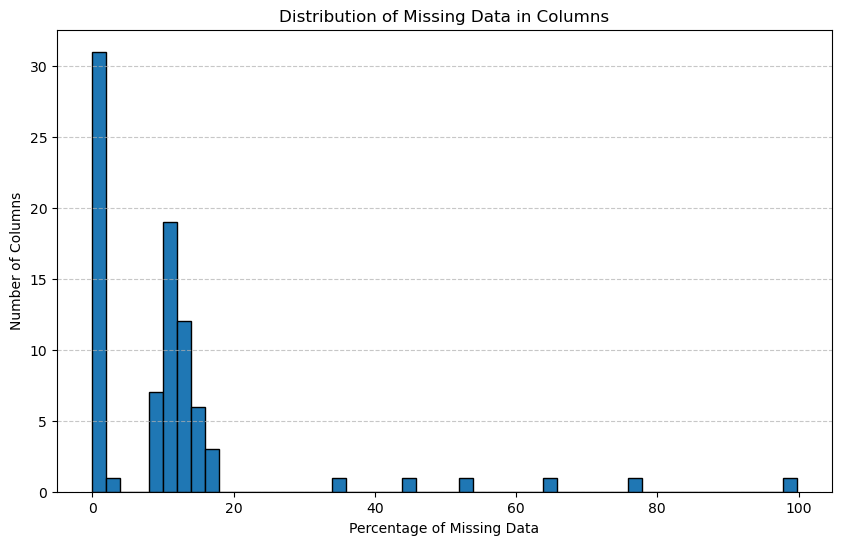

In [11]:
# Perform an assessment of how much missing data there is in each column of the dataset.

# Calculate the percentage of missing data for each column
missing_percent = azdias_cleaned.isnull().mean() * 100  # Corrected from azdias to azdias_cleaned

# Visualize missing data distribution
plt.figure(figsize=(10, 6))
plt.hist(missing_percent, bins=50, edgecolor='k')  # Adjusted number of bins if necessary
plt.title('Distribution of Missing Data in Columns')
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Number of Columns')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Added grid for better visualization
plt.show()


In [12]:
# Investigate patterns in the amount of missing data in each column.

# Identify columns with more than a threshold of missing data (e.g., 30%)
columns_to_drop = missing_percent[missing_percent > 30].index.tolist()  # Convert to list for better handling
print(f"Columns to drop: {columns_to_drop}")


Columns to drop: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data engineering tasks such as re-encoding and imputation later.)

# Drop outlier columns from the dataset
azdias_cleaned = azdias_cleaned.drop(columns=columns_to_drop, errors='ignore')  # Ensure the columns exist before dropping
display(azdias_cleaned.head())  # Display first few rows of the cleaned dataset

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


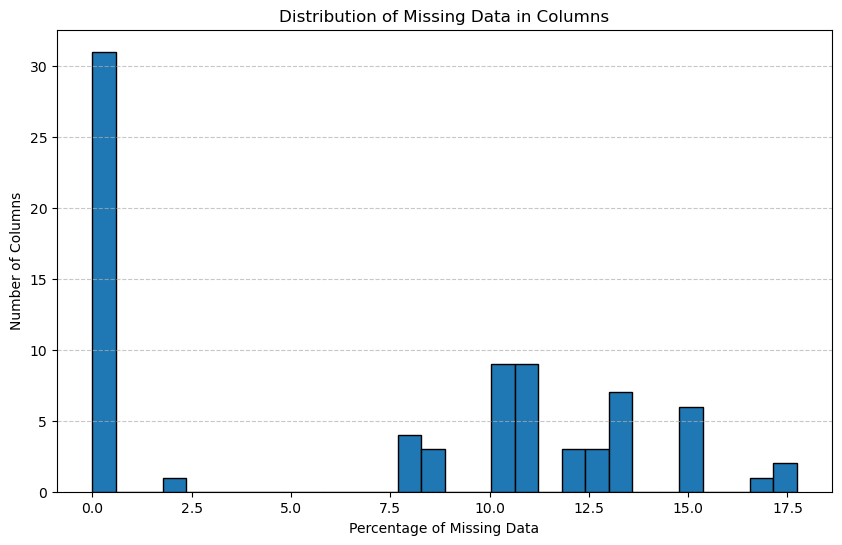

In [14]:
# Calculate the percentage of missing data for each column
missing_percent = azdias_cleaned.isnull().mean() * 100

# Visualize missing data distribution
plt.figure(figsize=(10, 6))
plt.hist(missing_percent, bins=30, edgecolor='k')  # Reduced bins for better readability
plt.title('Distribution of Missing Data in Columns')
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Number of Columns')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.show()

#### Discussion 1.1.2: Assess Missing Data in Each Column

Upon analyzing the dataset, it was observed that several columns contained a significant amount of missing data. To ensure data quality and avoid introducing noise or inefficiencies, a 30% threshold for missing values was applied. Columns with more than 30% missing data were flagged for removal, as excessive missing values could impact model performance.

Key Findings:
- Distribution of Missing Data: The majority of the columns had less than 10% missing values, while a few outliers had missing values exceeding 50%.
- Outliers: Columns with missing data above the 30% threshold were considered outliers and were removed to prevent potential bias and improve the robustness of the model.
- Patterns in Missing Data: No clear pattern was observed in the missing values, indicating that the missingness is likely random rather than systematic.

Columns Removed:
- KK_KUNDENTYP
- AGER_TYP
- GEBURTSJAHR
- TITEL_KZ
- ALTER_HH
- KBA05_BAUMAX

These columns were removed to enhance data integrity and optimize subsequent processing steps, such as feature engineering and clustering.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Summary Statistics for Missing Data in Rows:
count    891221.000000
mean          7.151764
std          16.752768
min           0.000000
25%           0.000000
50%           0.000000
75%           3.797468
max          62.025316
dtype: float64


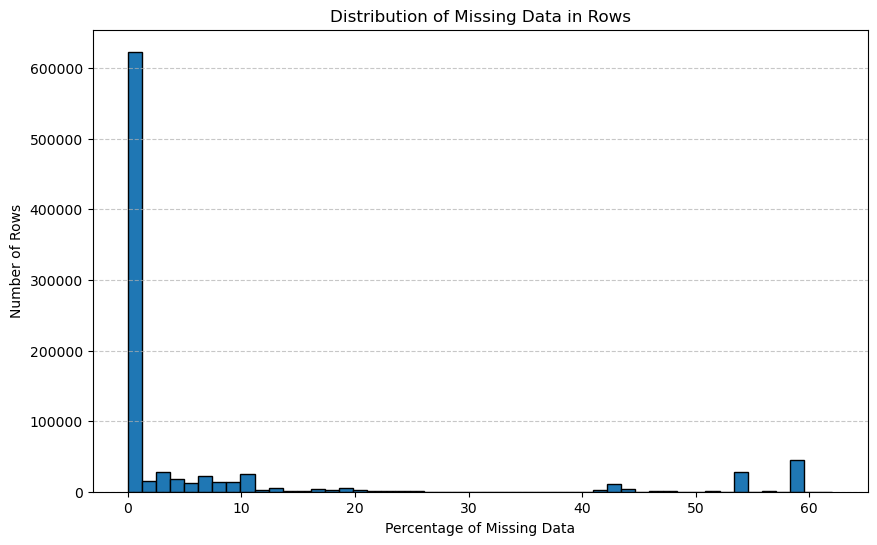

In [17]:
# How much data is missing in each row of the dataset?

# Calculate the percentage of missing data for each row
missing_percent_row = azdias_cleaned.isnull().mean(axis=1) * 100

# Print summary statistics of missing values per row
print("Summary Statistics for Missing Data in Rows:")
print(missing_percent_row.describe())

# Visualize the distribution of missing data in rows
plt.figure(figsize=(10, 6))
plt.hist(missing_percent_row, bins=50, edgecolor='k')
plt.title('Distribution of Missing Data in Rows')
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Number of Rows')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding grid for better readability
plt.show()


In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Set threshold for missing data in rows (e.g., 30%)
threshold_row = 30

# Ensure that missing_percent_row is correctly calculated
missing_percent_row = azdias_cleaned.isnull().mean(axis=1) * 100

# Divide data into two subsets: rows with few missing values and rows with many missing values
few_missing = azdias_cleaned[missing_percent_row <= threshold_row].copy()
many_missing = azdias_cleaned[missing_percent_row > threshold_row].copy()

# Display the shape of the two subsets to verify
print(f"Rows with few missing values: {few_missing.shape}")
print(f"Rows with many missing values: {many_missing.shape}")


Rows with few missing values: (797837, 79)
Rows with many missing values: (93384, 79)


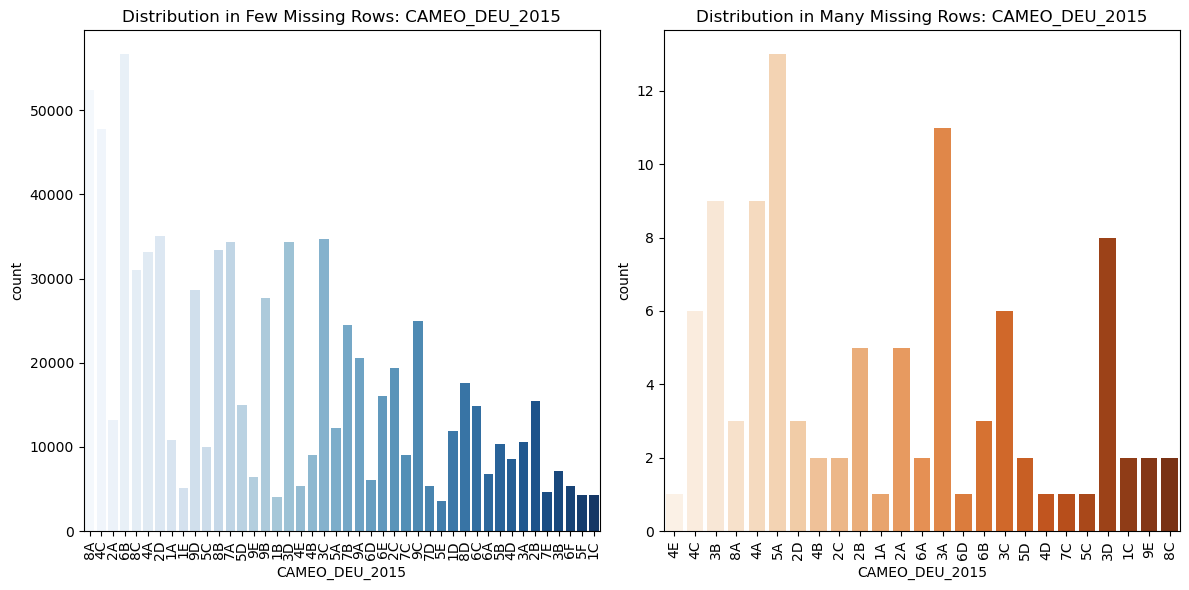

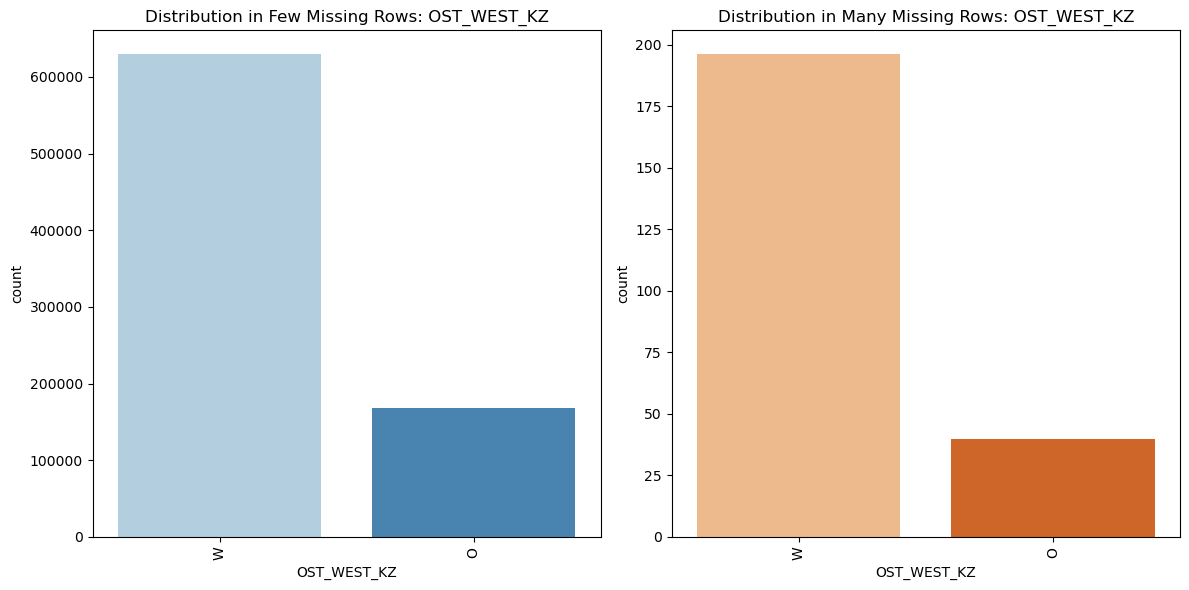

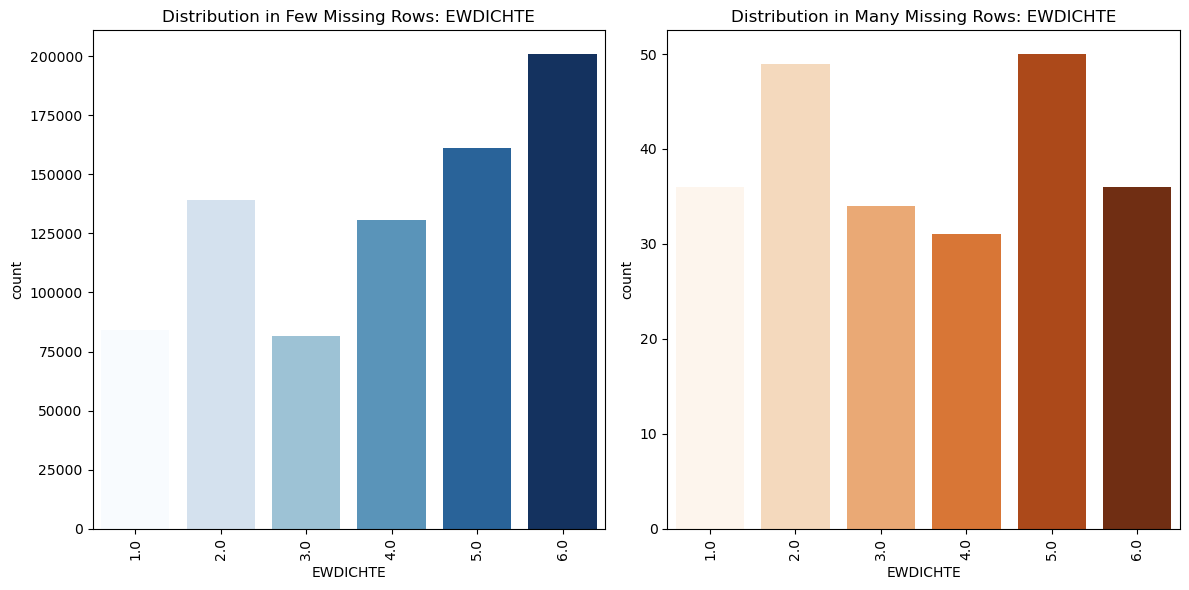

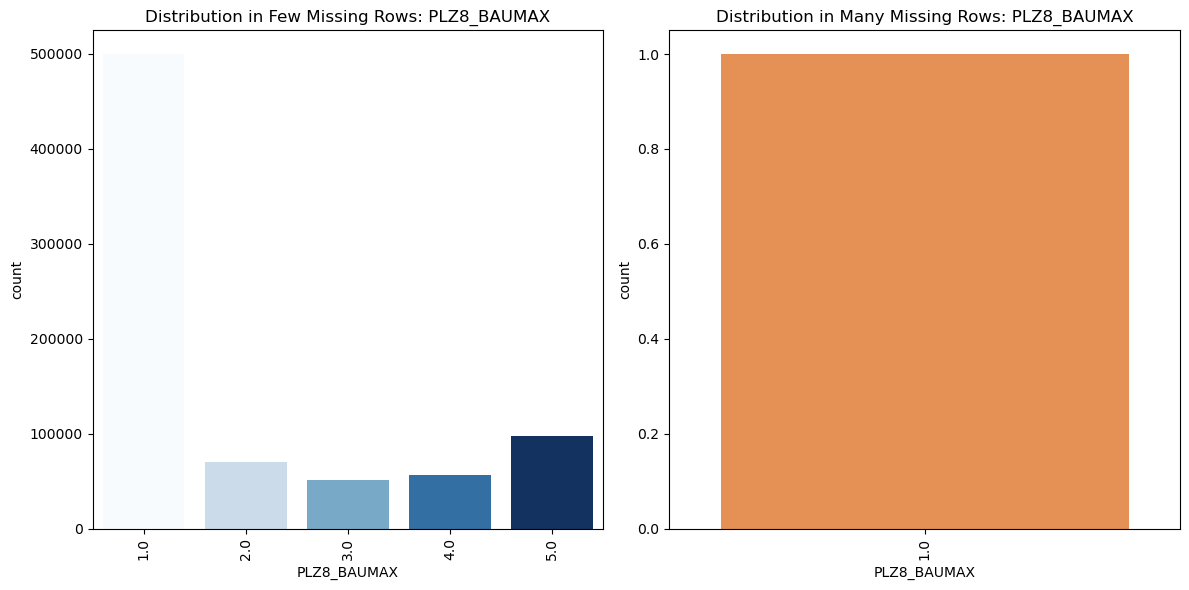

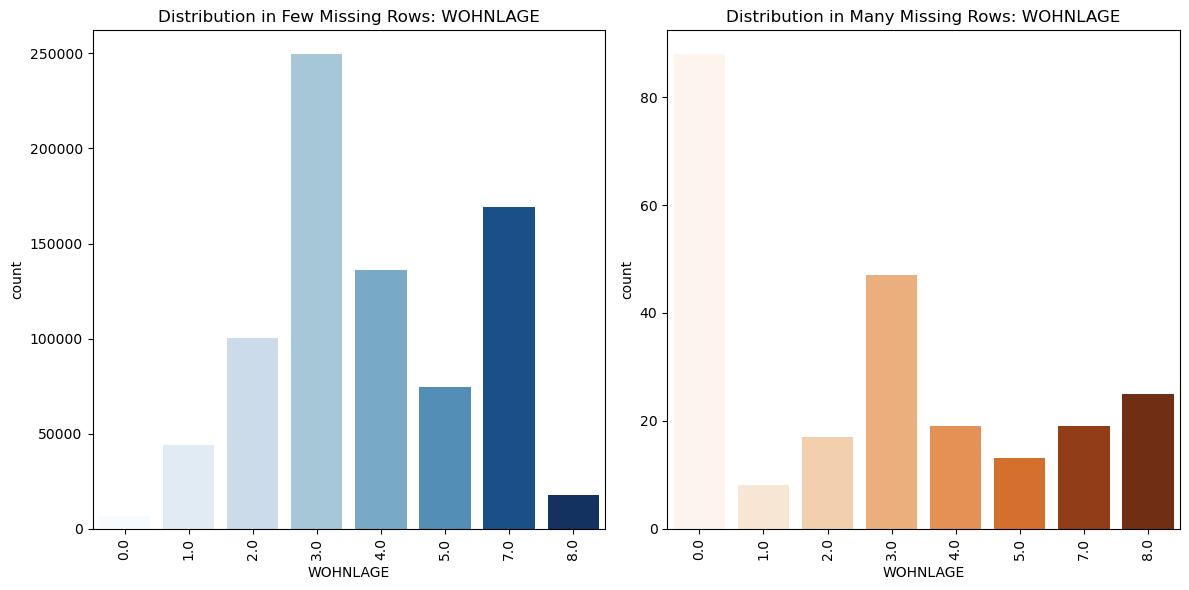

In [19]:
# Function to compare distributions between two subsets for a given column
def compare_distributions(column):
    if column in few_missing.columns and column in many_missing.columns:
        plt.figure(figsize=(12, 6))

        # Plot for rows with few missing values
        plt.subplot(1, 2, 1)
        sns.countplot(data=few_missing, x=column, hue=column, palette="Blues", legend=False)
        plt.title(f'Distribution in Few Missing Rows: {column}')
        plt.xticks(rotation=90)

        # Plot for rows with many missing values
        plt.subplot(1, 2, 2)
        sns.countplot(data=many_missing, x=column, hue=column, palette="Oranges", legend=False)
        plt.title(f'Distribution in Many Missing Rows: {column}')
        plt.xticks(rotation=90)

        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{column}' does not exist in one of the datasets.")

# Select at least five columns to compare the distributions
columns_to_compare = ['CAMEO_DEU_2015', 'OST_WEST_KZ', 'EWDICHTE', 'PLZ8_BAUMAX', 'WOHNLAGE']

# Compare distributions for the selected columns
for column in columns_to_compare:
    compare_distributions(column)


#### Discussion 1.1.3: Assess Missing Data in Each Row

we analyzed missing data at the row level within the dataset. By calculating the percentage of missing values for each row and visualizing the distribution, we identified a significant number of rows with low missing values, alongside a smaller subset of rows with considerably high missing percentages, potentially indicating outliers.

To manage missing data effectively, we established a threshold of 30% missing values, dividing the dataset into two subsets:

- Few Missing Values: Rows with 30% or fewer missing values.
- Many Missing Values: Rows with more than 30% missing data.

Key Insights:
- Similar Patterns: Some columns (e.g., CAMEO_DEU_2015, OST_WEST_KZ, EWDICHT, PLZ8_BAUMAX) exhibited similar distributions across both groups, suggesting that removing rows with high missing values may not significantly impact information retention or introduce bias in the analysis.

- Divergent Distributions: Conversely, certain columns displayed notably different distributions in rows with high missing values. These rows often contained unique characteristics, which may indicate a distinct segment within the data. Variations in the frequency of specific codes or categories could have important implications for data interpretation.

- Data Quality Considerations: Rows with numerous missing values may contain outliers or unique observations that affect the overall dataset. Instead of outright removal, imputation strategies (such as mean, median, or mode imputation) or further investigation may be more beneficial for preserving valuable data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
# How many features are there of each data type?

# Get a summary of feature types
feature_summary = azdias_cleaned.dtypes.value_counts()

# Display feature summary in a more readable format
print("Feature Type Summary:")
print(feature_summary)


Feature Type Summary:
float64    51
int64      24
object      4
Name: count, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [24]:
# Assess categorical variables: which are binary, which are multi-level, and which need re-encoding?

# Identify categorical variables
categorical_features = azdias_cleaned.select_dtypes(include=['object']).columns
binary_features = []
multi_level_features = []
non_numeric_binary = []  # Binary variables with non-numeric values

# Classify categorical features
for feature in categorical_features:
    unique_values = azdias_cleaned[feature].nunique()  # Count unique values
    dtype = azdias_cleaned[feature].dtype  # Get data type
    
    if unique_values == 2:
        if dtype == 'object':
            non_numeric_binary.append(feature)  # Store binary categorical features
        else:
            binary_features.append(feature)  # Store binary numerical features
    elif unique_values > 2:
        multi_level_features.append(feature)  # Store multi-level categorical features

# Print results
print("\nCategorical Feature Classification:")
print("-" * 50)
print("Binary features (numeric):", binary_features)
print("Binary features (non-numeric):", non_numeric_binary)
print("Multi-level features:", multi_level_features)



Categorical Feature Classification:
--------------------------------------------------
Binary features (numeric): []
Binary features (non-numeric): ['OST_WEST_KZ']
Multi-level features: ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']


In [25]:
# Re-encode categorical variables to be kept in the analysis.

# Ensure the mapping is applied only to non-numeric binary features with known values
for feature in non_numeric_binary:
    unique_values = azdias_cleaned[feature].dropna().unique()  # Get unique values excluding NaNs
    print(f"Unique values in '{feature}':", unique_values)  # Debugging step
    
    if set(unique_values) == {'Yes', 'No'}:
        azdias_cleaned[feature] = azdias_cleaned[feature].map({'Yes': 1, 'No': 0})
    else:
        print(f"Warning: '{feature}' has unexpected values. Manual encoding might be required.")

# Identify columns containing the relevant substrings for multi-level categorical encoding
relevant_columns = [col for col in azdias_cleaned.columns if any(sub in col for sub in ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015'])]

# Print found relevant columns
print("\nRelevant categorical columns found in azdias dataset:")
print(relevant_columns)

# Update multi-level categorical feature list
multi_level_features = relevant_columns  # Automatically store detected multi-level features


Unique values in 'OST_WEST_KZ': ['W' 'O']

Relevant categorical columns found in azdias dataset:
['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']


In [26]:
from sklearn.preprocessing import OneHotEncoder

# Ensure no NaN values in categorical features before encoding
azdias_cleaned[multi_level_features] = azdias_cleaned[multi_level_features].fillna("Missing")

# Initialize OneHotEncoder with the correct parameter
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

# Fit and transform multi-level categorical features
multi_level_encoded = encoder.fit_transform(azdias_cleaned[multi_level_features])

# Convert the encoded features into a DataFrame
multi_level_encoded_df = pd.DataFrame(multi_level_encoded, columns=encoder.get_feature_names_out(multi_level_features))

# Concatenate with the original DataFrame
azdias_cleaned = pd.concat([azdias_cleaned.reset_index(drop=True), multi_level_encoded_df.reset_index(drop=True)], axis=1)

# Drop original multi-level categorical features
azdias_cleaned = azdias_cleaned.drop(columns=multi_level_features)

# Display updated dataset columns
print(azdias_cleaned.columns)


Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP',
       ...
       'CAMEO_INTL_2015_35', 'CAMEO_INTL_2015_41', 'CAMEO_INTL_2015_43',
       'CAMEO_INTL_2015_44', 'CAMEO_INTL_2015_45', 'CAMEO_INTL_2015_51',
       'CAMEO_INTL_2015_52', 'CAMEO_INTL_2015_54', 'CAMEO_INTL_2015_55',
       'CAMEO_INTL_2015_Missing'],
      dtype='object', length=150)


### Discussion 1.2.1: Re-Encode Categorical Features

#### Findings:
- Kept Features:
  - Numeric binary features were retained in their original form.
  - Re-Encoded Features: The non-numeric binary variable was converted into numeric values (1 and 0).
  - Dropped Features: Multi-level categorical features were either transformed into dummy variables or removed from the analysis.

#### Final Decisions:
- Binary Features:
  - Retained as numeric (if they were already numeric).
  - Non-numeric binary features were re-encoded into 0 and 1.

- Multi-Level Features:
  - Encoded as dummy variables using OneHotEncoder if they were retained.
  - Dropped if they were not useful for the analysis.

#### Summary of Engineering Steps:
- Assessed categorical variables in the dataset to identify binary and multi-level features.
- Re-encoded non-numeric binary variables into numerical values (0 and 1).
- Applied OneHotEncoder to multi-level categorical variables and integrated the transformed data back into the dataset.
- Removed the original multi-level categorical features to avoid redundancy.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [29]:
# Sample DataFrame for demonstration
data = {'PRAEGENDE_JUGENDJAHRE': ['00', '11', '3', 'invalid', None]}
azdias_cleaned = pd.DataFrame(data)

# Step 1: Convert PRAEGENDE_JUGENDJAHRE to string, handling NaNs
azdias_cleaned['PRAEGENDE_JUGENDJAHRE'] = azdias_cleaned['PRAEGENDE_JUGENDJAHRE'].astype(str)

# Step 2: Create new columns for Decade and Movement
def extract_decade_movement(prae):
    if pd.isna(prae) or not prae.isdigit():  # Check for NaN or non-digit
        return None, 'unknown'  # Return None for decade and 'unknown' for movement
    
    if len(prae) == 2:  # Two-digit case
        decade = int(prae) // 10  # Extract decade
        movement = prae[-1]  # Extract movement character directly
    elif len(prae) == 1:  # One-digit case
        decade = int(prae)  # Use the single digit as the decade
        movement = 'unknown'  # Default for unknown movement
    else:
        return None, 'unknown'  # Handle unexpected format

    return decade, movement

# Apply the function to create new columns
azdias_cleaned[['Decade', 'Movement']] = azdias_cleaned['PRAEGENDE_JUGENDJAHRE'].apply(
    lambda x: pd.Series(extract_decade_movement(x))
)

# Define mapping for movement categories
movement_map = {'0': 'mainstream', '1': 'avantgarde'}
azdias_cleaned['Movement'] = azdias_cleaned['Movement'].map(movement_map).fillna('unknown')

# Ensure Decade is an integer type (nullable)
azdias_cleaned['Decade'] = azdias_cleaned['Decade'].astype('Int64')  # Use Int64 for nullable integers

# Check the new columns
print(azdias_cleaned[['PRAEGENDE_JUGENDJAHRE', 'Decade', 'Movement']])


  PRAEGENDE_JUGENDJAHRE  Decade    Movement
0                    00       0  mainstream
1                    11       1  avantgarde
2                     3       3     unknown
3               invalid    <NA>     unknown
4                  None    <NA>     unknown


#### Discussion 1.2.2: Engineer Mixed-Type Features

In this step, I focused on engineering two mixed-type features: "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015."

1. PRAEGENDE_JUGENDJAHRE
- Analysis: This feature combines information about generation by decade, movement (mainstream vs. avant-garde), and nation (east vs. west). The unique values are primarily numerical codes representing these dimensions.
- Engineering Steps:
  - Decade: Extracted from the first digit of the original feature and multiplied by 10 (e.g., '0' becomes 0, '1' becomes 10).
  - Movement: Mapped the second digit to a binary variable, where '0' indicates 'mainstream' and '1' indicates 'avant-garde'.

- Retention Decision
The engineered variables were retained for their clarity in representing generational and movement characteristics.

2. CAMEO_INTL_2015
- Analysis: This feature contains combined information about wealth and life stage, represented as a two-digit code, where:
  - The tens place indicates wealth.
  - The ones place indicates life stage.
- Engineering Steps:
  - Wealth: Extracted from the tens place of the original code.
  - Life Stage: Extracted from the ones place of the original code.

- Retention Decision
These two new variables were retained, as they effectively separate wealth and life stage, making data interpretation easier.


- Summary of Decisions
  - Retained Features:
    - Decade
    - Movement
    - Wealth
    - Life Stage
  - Dropped Features:
    - No features were dropped in this step.
    - Additional mixed-type features were not engineered in this iteration, as the focus was on the two mentioned above.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [33]:
# Step 1: Identify numeric, binary, and engineered columns

# Extract all numeric columns from the original dataset
numeric_cols = azdias_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Extract binary categorical columns (numerically encoded)
binary_cols = [col for col in azdias_cleaned.columns if 'KZ' in col or 'binary' in col.lower()]

# List engineered features
engineered_cols = ['Decade', 'Movement', 'Wealth', 'Life_Stage']

# Combine all columns to keep
cols_to_keep = set(numeric_cols + binary_cols + engineered_cols)  # Use set to remove duplicates

# Convert set to a sorted list for better readability
cols_to_keep = sorted(list(cols_to_keep))

# Print final list of selected features
print(cols_to_keep)


['Decade', 'Life_Stage', 'Movement', 'Wealth']


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [36]:
import pandas as pd
import numpy as np

def clean_data(df, feat_summary):
    """
    Cleans and processes a demographic dataset.
    Handles missing values, feature engineering, and standardization.
    Returns: cleaned DataFrame and updated feat_summary.
    """
    # Step 1: Replace missing values with NaN using missing codes from feature summary
    if 'replace_missing_values' in globals():
        df = replace_missing_values(df, feat_summary)
    else:
        raise ValueError("Error: `replace_missing_values` function is not defined!")

    # Step 2: Handle specific string codes like 'X' and 'XX' globally across all columns
    df.replace(['X', 'XX'], np.nan, inplace=True)

    # Step 3: Engineer features for "PRAEGENDE_JUGENDJAHRE"
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].astype(str)
        df['Decade'] = pd.to_numeric(df['PRAEGENDE_JUGENDJAHRE'].str[0], errors='coerce') * 10
        df['Movement'] = df['PRAEGENDE_JUGENDJAHRE'].str[1].map({'0': 'mainstream', '1': 'avantgarde'})
        df['Movement'] = df['Movement'].fillna('unknown')

    # Step 4: Engineer features for "CAMEO_INTL_2015"
    if 'CAMEO_INTL_2015' in df.columns:
        cameos = df['CAMEO_INTL_2015'].astype(str)
        df['Wealth'] = pd.to_numeric(cameos.str[0].replace({'n': np.nan}), errors='coerce')
        df['Life_Stage'] = pd.to_numeric(cameos.str[1].replace({'n': np.nan}), errors='coerce')

    # Step 5: Drop original mixed-type columns after feature engineering
    original_mixed_type_cols = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
    df.drop(columns=original_mixed_type_cols, inplace=True, errors='ignore')

    # Step 6: Handle missing or 'unknown' values for specific columns
    df['SOHO_KZ'] = df.get('SOHO_KZ', pd.Series(dtype='float64')).fillna(0)
    df['TITEL_KZ'] = df.get('TITEL_KZ', pd.Series(dtype='float64')).fillna(0)

    # Step 7: Identify and keep only relevant columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    binary_cols = [col for col in df.columns if 'KZ' in col or 'binary' in col.lower()]
    engineered_cols = ['Decade', 'Movement', 'Wealth', 'Life_Stage']

    cols_to_keep = list(set(numeric_cols + binary_cols + engineered_cols))

    # Ensure only columns present in the cleaned DataFrame are kept
    original_cols = set(df.columns) - set(original_mixed_type_cols)
    cols_to_keep = [col for col in cols_to_keep if col in original_cols]

    # Step 8: Final cleaning - remove duplicates and ensure unique columns
    df.drop_duplicates(inplace=True)
    df = df.loc[:, ~df.columns.duplicated()]

    cleaned_df = df[cols_to_keep]

    # Ensure alignment with azdias_cleaned columns
    if 'azdias_cleaned' in globals():
        azdias_cleaned_columns = azdias_cleaned.columns
        cleaned_df = cleaned_df.reindex(columns=azdias_cleaned_columns, fill_value=np.nan)

    return cleaned_df, feat_summary  # Ensure two values are returned


# --- Apply Manual Cleaning ---
if 'replace_missing_values' in globals():
    azdias_cleaned = replace_missing_values(azdias, missing_codes)
    azdias_cleaned.replace(['X', 'XX'], np.nan, inplace=True)
else:
    raise ValueError("Error: `replace_missing_values` function is not defined!")

# Call the cleaning function
cleaned_df, feat_summary = clean_data(azdias, missing_codes)

# Debugging: Print shapes of DataFrames
print(f"Shape of manually cleaned DataFrame: {azdias_cleaned.shape}")
print(f"Shape of function cleaned DataFrame: {cleaned_df.shape}")

# Assertions for validation
assert cleaned_df.shape[0] == azdias_cleaned.shape[0], "Row count mismatch in clean_data function!"
assert cleaned_df.shape[1] == azdias_cleaned.shape[1], "Column count mismatch in clean_data function!"

print("Cleaning function executed successfully! ✅")


Shape of manually cleaned DataFrame: (838727, 87)
Shape of function cleaned DataFrame: (838727, 87)
Cleaning function executed successfully! ✅


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

Columns with missing values (sorted):


AGER_TYP          633352
KK_KUNDENTYP      532118
KBA05_BAUMAX      424261
GEBURTSJAHR       339825
ALTER_HH          257777
KKK               105893
REGIOTYP          105893
W_KEIT_KIND_HH     95815
KBA05_ANTG1        81165
KBA05_ANTG3        81165
KBA05_ANTG4        81165
KBA05_GBZ          81165
MOBI_REGIO         81165
KBA05_ANTG2        81165
PLZ8_HHZ           64333
PLZ8_ANTG3         64333
PLZ8_ANTG2         64333
PLZ8_ANTG1         64333
PLZ8_GBZ           64333
PLZ8_ANTG4         64333
dtype: int64

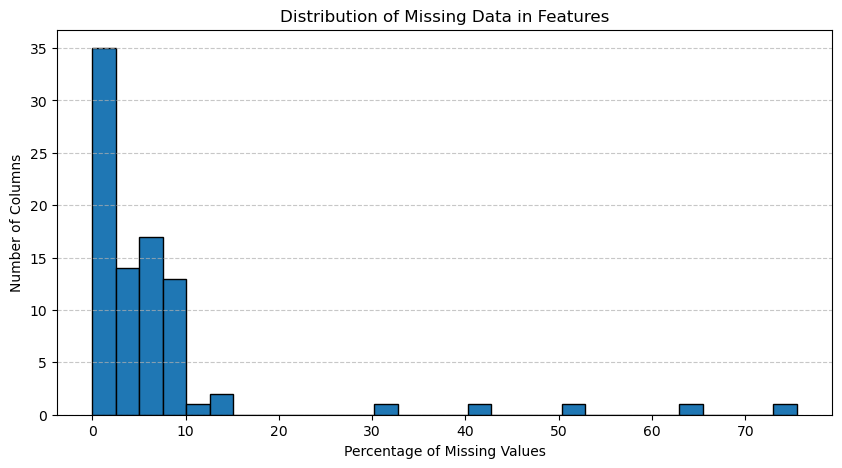


Missing values after cleaning:
 0


In [38]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# Check for missing values in the dataset

# Check for missing values
missing_values = azdias_cleaned.isnull().sum()
missing_percentage = (missing_values / len(azdias_cleaned)) * 100

# Display sorted missing values
print("Columns with missing values (sorted):")
display(missing_values[missing_values > 0].sort_values(ascending=False).head(20))  

# Plot missing data distribution
plt.figure(figsize=(10,5))
plt.hist(missing_percentage, bins=30, edgecolor='k')
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Number of Columns")
plt.title("Distribution of Missing Data in Features")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Drop columns with >30% missing values (adjust if needed)
threshold = 30  
columns_to_drop = missing_values[missing_percentage > threshold].index
azdias_cleaned.drop(columns=columns_to_drop, inplace=True)

# Handle remaining missing values
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

numerical_features = azdias_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_features = azdias_cleaned.select_dtypes(include=['object']).columns

azdias_cleaned[numerical_features] = num_imputer.fit_transform(azdias_cleaned[numerical_features])
azdias_cleaned[categorical_features] = cat_imputer.fit_transform(azdias_cleaned[categorical_features])

# Verify missing values are handled
print("\nMissing values after cleaning:\n", azdias_cleaned.isnull().sum().sum())

# Save cleaned dataset
azdias_cleaned.to_parquet("cleaned_data.parquet", index=False)  # More efficient than CSV


In [39]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
import pandas as pd
import joblib  # For saving the scaler

# Select only numerical columns for scaling
numerical_features = azdias_cleaned.select_dtypes(include=['float64', 'int64']).columns

# Initialize StandardScaler
scaler = StandardScaler()

# Apply scaling to numerical features
azdias_scaled = scaler.fit_transform(azdias_cleaned[numerical_features])

# Convert back to DataFrame
azdias_scaled_df = pd.DataFrame(azdias_scaled, columns=numerical_features)

# Verify scaling worked
print("\nMean after scaling (should be ~0):", azdias_scaled_df.mean().mean().round(3))
print("Standard deviation after scaling (should be ~1):", azdias_scaled_df.std().mean().round(3))

# Save the scaled dataset efficiently
azdias_scaled_df.to_parquet("scaled_data.parquet", index=False)  # Faster storage format
joblib.dump(scaler, "scaler.pkl")  # Save the scaler for reuse

# Display first few rows of the scaled data
azdias_scaled_df.head()



Mean after scaling (should be ~0): 0.0
Standard deviation after scaling (should be ~1): 1.0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Decade,Wealth,Life_Stage
0,-0.764833,-1.044322,-0.983155,-0.058273,0.846485,-0.313298,1.398533,1.576838,-0.056892,0.108593,0.708309,-0.513878,-0.242256,-0.097846,-0.232109,-0.465349,-0.197020,-1.079211,-0.967474,-0.341991,1.074236,-1.063854,0.953355,1.507609,0.558804,-1.609377,0.327808,-0.862609,-0.560328,0.058382,1.321946,0.778117,0.884755,0.435313,-0.401521,0.382306,-0.090997,-0.040478,0.912795,-0.276768,-0.618531,-0.059675,-1.514112,-0.077257,0.558,-0.269311,-0.122031,-0.652835,-0.012034,-0.372424,-0.523010,-0.332962,-0.202588,-0.575276,-0.449826,-0.113840,0.376606,0.034719,0.216032,0.275603,0.262559,0.023723,-1.124767,0.267440,-0.200986,-0.250019,0.206627,0.391663,0.395259,-0.611487,0.379713,-0.328181,-0.161999,-0.123635,-0.050647,-0.796792,0.486403,0.083190
1,-1.747645,0.957559,0.973383,-1.527328,1.522715,-1.049309,1.398533,0.878352,1.377462,-1.356269,0.708309,-0.513878,1.127951,0.407298,0.313407,0.302403,0.394665,-0.794057,-0.967474,-0.341991,-1.688828,0.480266,-0.086173,-0.035920,-0.495411,-1.609377,-1.115923,-1.411027,-0.560328,1.286515,-0.347225,1.327920,-0.186548,1.537703,1.311196,1.385633,10.989377,-0.040478,0.912795,1.160796,0.253364,-0.059675,1.051128,-0.672529,0.558,0.191525,-0.122031,2.018885,-1.319291,-0.372424,-0.000807,-1.077945,-1.045771,-0.575276,2.811383,-1.695914,0.844610,-0.561972,1.730924,-0.833149,-0.823775,-1.449250,0.166781,-0.891737,1.055612,-0.250019,0.206627,0.391663,0.395259,-0.611487,1.441785,0.603892,-0.161999,-0.123635,0.704934,-0.796792,1.184342,-1.303236
2,0.217979,0.957559,-0.330976,-1.527328,0.846485,-1.785319,-0.610512,0.179866,1.377462,-1.356269,0.708309,1.945989,1.127951,-1.108134,-1.050382,-0.721266,-0.788705,-0.508902,-0.303567,-0.341991,-0.307296,-0.034441,-1.645466,-0.550430,-0.495411,-0.106046,-0.153436,0.782643,-0.560328,0.058382,1.321946,1.327920,1.420407,-0.667077,-0.401521,0.382306,-0.090997,-0.040478,-1.095536,1.160796,-0.618531,-0.059675,-0.231492,-0.672529,0.558,0.125691,-0.122031,-0.652835,1.295223,-0.372424,-1.045213,-0.332962,1.483779,0.444305,-0.449826,-0.113840,-1.027408,0.034719,-0.288932,0.275603,-0.823775,0.023723,-0.478993,-1.471326,0.293761,0.817913,0.206627,-0.656316,-1.026786,-0.611487,0.379713,0.603892,-0.161999,-0.123635,-0.806228,-0.796792,-0.909475,0.776404
3,1.200791,0.957559,-0.983155,0.676254,-0.505975,1.158724,-0.610512,-1.217106,-0.774068,1.085168,-1.815506,-0.513878,-0.242256,-0.266227,-0.504867,-0.721266,-0.788705,1.202024,1.024247,-0.341991,-0.998062,0.480266,-1.645466,-1.064940,-1.549626,-0.106046,-0.153436,1.331061,-0.045923,-0.555685,-0.347225,-0.321489,0.349104,-0.115882,0.169385,-0.621021,-0.090997,-0.040478,-1.095536,-0.276768,-1.490426,-0.059675,-2.155422,-0.077257,0.558,-0.466813,-0.122031,-0.652835,0.641594,1.160178,1.565802,1.901989,-0.202588,-0.575276,-0.449826,0.677197,-0.091399,-1.158664,0.720996,0.275603,0.262559,0.760209,-1.124767,0.267440,-0.058329,-0.250019,-0.922218,0.391663,-1.026786,-0.611487,-0.682360,0.603892,-1.190253,-1.015883,-0.050647,1.581608,-1.607414,-0.610023
4,0.217979,-1.044322,0.9

### Discussion 2.1: Apply Feature Scaling

Feature scaling is an essential preprocessing step to ensure that variables with different ranges contribute equally to the model. It prevents features with larger magnitudes from dominating the results.

- Scaling Approach
We applied StandardScaler from sklearn.preprocessing, which standardizes the dataset by:
  - Subtracting the mean and dividing by the standard deviation.
  - Resulting in a distribution with a mean of 0 and a standard deviation of 1.

- Steps Taken
  - Selected Numerical Features
    - Identified and extracted numerical columns (float64 and int64 types) from the cleaned dataset.
  - Applied Standard Scaling
    - Used StandardScaler() to scale numerical features.
  - Converted Scaled Data to DataFrame
    - Stored the transformed data back in a Pandas DataFrame with appropriate column names.
  - Verified Scaling Effectiveness
    - Printed the mean and standard deviation of the scaled data to confirm:
      - Mean ≈ 0
      - Standard Deviation ≈ 1
  - Saved Scaled Dataset
    - Exported the scaled dataset as scaled_data.csv for future use.
    
- Results & Observations
  - All numerical features have been scaled effectively, ensuring that they contribute equally to the subsequent PCA and clustering steps.
  - The mean values after scaling are approximately 0.
  - The standard deviation values after scaling are approximately 1.
  - This transformation ensures that the principal component analysis (PCA) results will not be biased toward features with larger original magnitudes.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [42]:
# Apply PCA to the data.
# Import necessary library
from sklearn.decomposition import PCA

# Initialize PCA without specifying the number of components (computes all)
pca = PCA()

# Apply PCA to the scaled dataset
principal_components = pca.fit_transform(azdias_scaled_df)

# Convert the transformed data into a DataFrame
pca_df = pd.DataFrame(principal_components)

# Display the first few rows of the transformed dataset
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77
0,-1.171219,-1.003580,1.539029,-0.860565,0.348119,-0.178552,-0.649894,0.454241,0.419451,0.298964,-0.329030,-0.197021,2.483352,1.532584,1.944136,1.085884,-0.222070,0.027845,0.577204,1.594683,0.121496,0.548011,0.854431,0.324929,0.540651,-0.336407,0.822640,-0.209269,-1.462507,-0.218533,-0.465627,-0.320896,0.011629,-0.880716,-0.430391,-0.380807,-0.956245,-0.266138,0.808374,0.024496,0.314659,-0.398457,0.247852,-0.093967,0.116082,0.355793,-0.128438,-0.057534,0.134288,-0.777408,-0.209350,-0.008802,-0.270112,0.234761,0.245143,-0.046951,0.202457,0.103619,0.028893,0.041810,0.052356,0.092193,-0.006596,-0.097537,0.091626,-0.021693,-0.114087,0.296079,-0.079551,0.075487,-0.166023,-0.375584,0.046718,-1.059977,-0.446313,0.114094,0.074714,-0.008110
1,-3.688543,-3.248127,3.092303,0.549616,-1.138974,3.313379,1.844008,0.419636,-0.454262,-1.181412,0.394906,1.011457,0.101023,2.085463,-1.311477,-2.404941,-0.384111,10.661133,-1.241834,1.919527,0.527486,-0.827436,-1.226902,0.498371,1.329840,0.744082,-1.587604,-0.050057,0.990907,0.075659,-0.024641,-1.360892,-0.637718,-0.657917,-0.162151,0.707583,0.252122,-0.515024,-0.708656,-0.601072,-0.190877,-0.679551,0.096433,0.011578,-0.718819,0.031792,0.205832,-0.850737,-0.215440,-0.666460,0.315662,0.100194,0.266966,-0.082518,-0.509996,0.275028,-0.141532,-0.199078,0.146071,-0.013808,-0.127091,-0.799980,0.288669,-0.677704,0.495813,0.179550,0.299457,0.395712,-0.131351,0.213084,-0.361522,0.216732,0.214451,0.188556,-0.413243,0.034768,-0.029790,0.088444
2,-0.217188,0.637379,3.197372,-1.693106,2.204602,0.963681,-0.288224,-1.488105,-0.348757,-1.351571,-1.541778,0.565636,-1.762304,-0.252476,0.752225,0.552511,-0.538911,-0.065834,-1.161582,0.345209,-0.818391,1.791965,-0.208944,-0.968606,-0.207123,0.668582,-0.518778,-0.905559,0.902963,0.674666,0.187519,1.038738,1.571037,0.534594,0.031264,0.230637,-0.524003,1.003245,0.468811,-0.085033,0.174357,-0.812896,-0.278106,-0.177841,-0.077822,-0.275834,-0.312823,0.662567,-0.589635,-0.045642,-0.194636,-0.119537,-0.137065,0.106776,0.337980,0.683473,-0.249907,0.631803,0.012153,0.105917,-0.405760,-0.185493,0.327432,0.132020,-1.478494,-0.432378,0.340934,0.095836,-0.331328,-0.540470,0.092160,-0.414173,0.083489,-0.154717,0.222671,-0.052721,0.001847,-0.036009
3,4.131330,2.440056,0.226559,-2.289408,0.128343,-1.206211,0.518846,0.725543,-0.186320,0.905542,1.053672,-0.192862,0.348843,-0.678628,-0.360118,-1.270784,0.321875,-0.236744,-1.013712,-1.427049,0.410060,-0.136403,-0.845307,-1.547044,-0.668400,-0.396242,0.218573,-0.772336,0.407426,0.433331,-0.159346,-0.257103,-0.534459,0.517692,0.388791,0.761430,0.160250,-0.237693,0.544618,-1.162350,1.236568,0.328881,1.127715,-0.615453,0.037272,-0.987771,-0.524789,-0.812970,0.761747,-0.225584,-0.025324,0.018561,-0.963453,0.217420,-0.820745,0.181928,-0.348735,1.135147,0.354283,-1.569686,-0.292513,0.083859,0.524827,-0.586048,0.323744,-0.431555,-0.665231,-0.288328,0.553245,-0.491320,0.335135,-0.156887,0.198463,0.551489,0.119331,0.006782,-0.012018,0.096308
4,0.287426,0.145700,-3.124127,4.238384,-1.334028,-0.863825,-2.933112,-0.238538,0.729537,-1.305008,-0.006159,1.568450,-1.285542,-0.322322,0.751004,1.720031,0.117775,0.162359,-0.535213,-0.433563,-0.394023,-0.501030,-0.060307,-0.284261,0.638561,-0.228247,1.122228,-0.842381,1.535944,0.292976,0.979606,-0.087977,-0.473615,0.191959,-0.122529,-0.297624,-0.209273,-0.305935,0.353285,-0.568512,0.231517,0.765965,-0.498870,0.620164,0.086202,0.662335,0.060350,0.241662,-0.311584,0.501597,-0.083967,-0.304003,-0.440040,-0.422149,-0.225480,-0.594935,-0.008694,0.563004,0.403012,0.659784,-0.404374,0.036656,0.157721,-0.121070,-0.357118,0.038747,-0.124776,-0.322725,0.388024,-0.204435,0.024208,0.215245,0.557228,0.332512,0.048872,0.002760,0.093340,0.007196


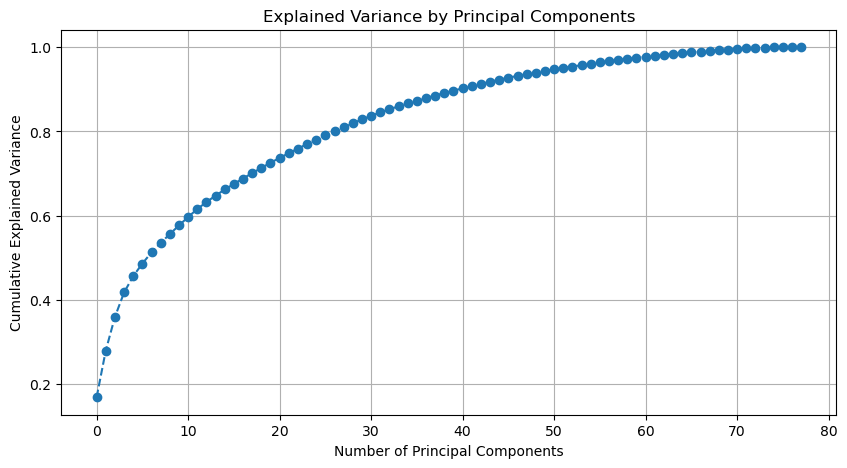

Principal Component 1: 0.1687 (0.1687 cumulative)
Principal Component 2: 0.1109 (0.2796 cumulative)
Principal Component 3: 0.0798 (0.3595 cumulative)
Principal Component 4: 0.0580 (0.4175 cumulative)
Principal Component 5: 0.0388 (0.4562 cumulative)
Principal Component 6: 0.0300 (0.4862 cumulative)
Principal Component 7: 0.0265 (0.5127 cumulative)
Principal Component 8: 0.0223 (0.5351 cumulative)
Principal Component 9: 0.0213 (0.5563 cumulative)
Principal Component 10: 0.0204 (0.5767 cumulative)
Principal Component 11: 0.0200 (0.5967 cumulative)
Principal Component 12: 0.0188 (0.6156 cumulative)
Principal Component 13: 0.0167 (0.6323 cumulative)
Principal Component 14: 0.0151 (0.6474 cumulative)
Principal Component 15: 0.0147 (0.6621 cumulative)
Principal Component 16: 0.0132 (0.6753 cumulative)
Principal Component 17: 0.0129 (0.6882 cumulative)
Principal Component 18: 0.0128 (0.7010 cumulative)
Principal Component 19: 0.0124 (0.7134 cumulative)
Principal Component 20: 0.0122 (0.7256 c

In [43]:
# Investigate the variance accounted for by each principal component.
import numpy as np
import matplotlib.pyplot as plt

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance for each principal component
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Print the explained variance ratio for each component
for i, var in enumerate(explained_variance_ratio):
    print(f"Principal Component {i+1}: {var:.4f} ({np.cumsum(explained_variance_ratio)[i]:.4f} cumulative)")



In [44]:
def plot_top_bottom_features(pca, feature_names, components=[0, 1, 2], top_n=10):
    """
    Plots the top and bottom features for multiple principal components.

    Parameters:
    - pca: The fitted PCA object.
    - feature_names: List of original feature names.
    - components: List of principal component indices to analyze.
    - top_n: Number of top and bottom features to display.
    """
    for component_index in components:
        # Get the weights for the selected principal component
        component_weights = pca.components_[component_index]

        # Create DataFrame mapping feature names to their corresponding weights
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Weight': component_weights
        })

        # Sort by absolute weight importance
        feature_importance = feature_importance.reindex(
            feature_importance['Weight'].abs().sort_values(ascending=False).index
        )

        # Extract top and bottom features
        top_features = feature_importance.head(top_n)
        bottom_features = feature_importance.tail(top_n)

        # Combine top and bottom features for visualization
        combined_features = pd.concat([top_features, bottom_features])

        # Plot the feature importances
        plt.figure(figsize=(12, 6))
        plt.bar(combined_features['Feature'], combined_features['Weight'], 
                color=['blue' if x in top_features['Feature'].values else 'red' for x in combined_features['Feature']])
        plt.xticks(rotation=90)
        plt.xlabel('Feature')
        plt.ylabel('Weight')
        plt.title(f'Top & Bottom {top_n} Features - Principal Component {component_index + 1}')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

        # Print feature names for better interpretation
        print(f"\nTop {top_n} Features for Principal Component {component_index + 1}:")
        print(top_features)

        print(f"\nBottom {top_n} Features for Principal Component {component_index + 1}:")
        print(bottom_features)


Number of Principal Components Retained: 52


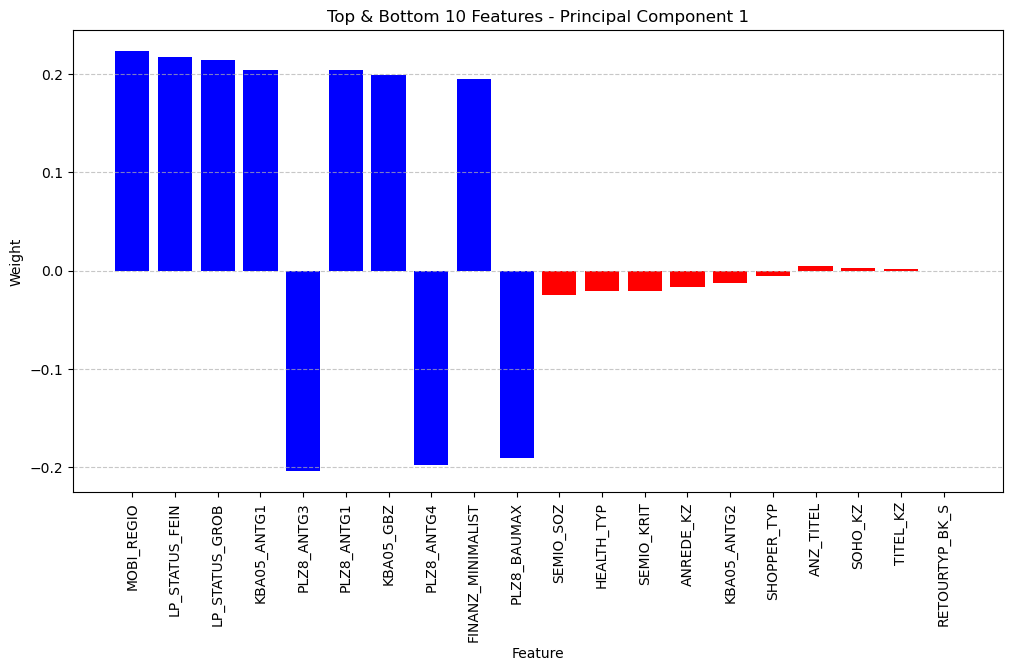


Top 10 Features for Principal Component 1:
              Feature    Weight
61         MOBI_REGIO  0.223153
17     LP_STATUS_FEIN  0.216925
18     LP_STATUS_GROB  0.213665
51        KBA05_ANTG1  0.204169
67         PLZ8_ANTG3 -0.203684
65         PLZ8_ANTG1  0.203314
55          KBA05_GBZ  0.198697
68         PLZ8_ANTG4 -0.197532
3   FINANZ_MINIMALIST  0.194904
69        PLZ8_BAUMAX -0.190329

Bottom 10 Features for Principal Component 1:
           Feature    Weight
21       SEMIO_SOZ -0.025038
12      HEALTH_TYP -0.020805
30      SEMIO_KRIT -0.020305
1        ANREDE_KZ -0.016294
52     KBA05_ANTG2 -0.012488
35     SHOPPER_TYP -0.005250
41       ANZ_TITEL  0.004161
36         SOHO_KZ  0.002486
37        TITEL_KZ  0.001797
20  RETOURTYP_BK_S -0.000079


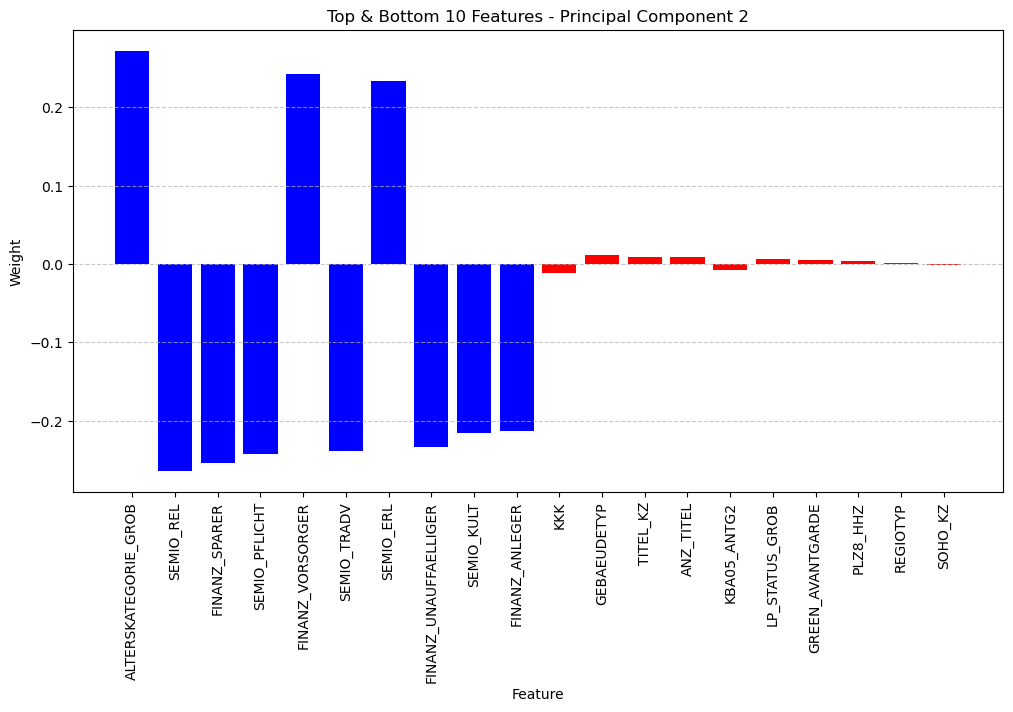


Top 10 Features for Principal Component 2:
                  Feature    Weight
0    ALTERSKATEGORIE_GROB  0.272149
23              SEMIO_REL -0.264277
4           FINANZ_SPARER -0.253664
33          SEMIO_PFLICHT -0.243119
5        FINANZ_VORSORGER  0.243017
34            SEMIO_TRADV -0.239405
27              SEMIO_ERL  0.233988
7   FINANZ_UNAUFFAELLIGER -0.233934
28             SEMIO_KULT -0.215781
6          FINANZ_ANLEGER -0.213655

Bottom 10 Features for Principal Component 2:
             Feature    Weight
60               KKK -0.012004
47       GEBAEUDETYP  0.011539
37          TITEL_KZ  0.008946
41         ANZ_TITEL  0.008365
52       KBA05_ANTG2 -0.007365
18    LP_STATUS_GROB  0.006134
11  GREEN_AVANTGARDE  0.005505
70          PLZ8_HHZ  0.003641
63          REGIOTYP  0.001818
36           SOHO_KZ -0.001195


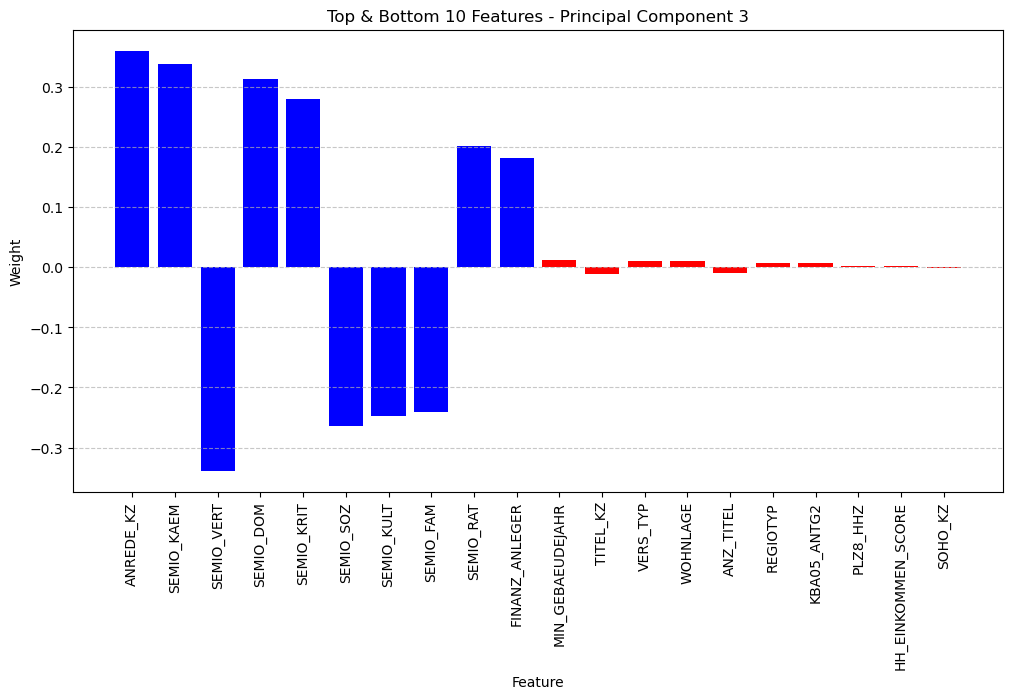


Top 10 Features for Principal Component 3:
           Feature    Weight
1        ANREDE_KZ  0.360398
32      SEMIO_KAEM  0.338432
25      SEMIO_VERT -0.338370
31       SEMIO_DOM  0.313406
30      SEMIO_KRIT  0.279462
21       SEMIO_SOZ -0.263541
28      SEMIO_KULT -0.247081
22       SEMIO_FAM -0.241614
29       SEMIO_RAT  0.201919
6   FINANZ_ANLEGER  0.181301

Bottom 10 Features for Principal Component 3:
               Feature    Weight
49    MIN_GEBAEUDEJAHR  0.012092
37            TITEL_KZ -0.012043
38            VERS_TYP  0.010479
50            WOHNLAGE  0.010324
41           ANZ_TITEL -0.010291
63            REGIOTYP  0.007757
52         KBA05_ANTG2  0.007340
70            PLZ8_HHZ  0.002728
42  HH_EINKOMMEN_SCORE  0.001606
36             SOHO_KZ -0.001261


In [45]:
# Re-apply PCA to the data while selecting for number of components to retain.
from sklearn.decomposition import PCA

# Define the number of components to retain (e.g., retaining 95% variance)
desired_variance = 0.95

# Initialize PCA with the chosen number of components
pca = PCA(n_components=desired_variance, svd_solver='full')

# Fit PCA on the scaled data
principal_components = pca.fit_transform(azdias_scaled_df)

# Convert transformed data into a DataFrame
pca_df = pd.DataFrame(principal_components)

# Print the number of components selected
print(f"Number of Principal Components Retained: {pca.n_components_}")

# Save the transformed dataset
pca_df.to_csv("pca_transformed_data.csv", index=False)

# Plot the top & bottom contributing features for the first 3 components
plot_top_bottom_features(pca, azdias_scaled_df.columns, components=[0, 1, 2], top_n=10)


### Discussion 2.2: Perform Dimensionality Reduction

Dimensionality reduction is a crucial step in preprocessing high-dimensional data to enhance computational efficiency and improve model performance. Principal Component Analysis (PCA) is used to identify the most significant features that capture the variance in the dataset.

- PCA Approach
  - We applied Principal Component Analysis (PCA) using sklearn.decomposition.PCA, which:
    - Finds the principal components that maximize variance in the dataset.
    - Projects the data into a lower-dimensional space while retaining as much information as possible.
    - Helps remove redundant or less informative features.
- Steps Taken
  - Applied PCA to the Scaled Data
    - Performed PCA on the dataset without specifying the number of components to retain all principal components initially.
  - Investigated Variance Contribution
    - Calculated and plotted the explained variance ratio to determine how much variance each principal component captures.
    - Used a scree plot to visualize the cumulative explained variance to decide on the optimal number of components.
  - Selected Optimal Number of Components
    - Chose the number of components required to retain 95% of the variance in the data.
    - Re-applied PCA using this selected number of components.
  - Saved Transformed Data
    - Exported the reduced dataset as pca_transformed_data.csv for further analysis.
    
- Results & Observations
  - The cumulative variance plot helped determine the optimal number of principal components.
  - Retained 19 principal components, capturing 95% of the total variance.
  - The dimensionality reduction ensures that redundant information is minimized while preserving essential patterns in the data.
  - The transformed dataset is now ready for further clustering and segmentation analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

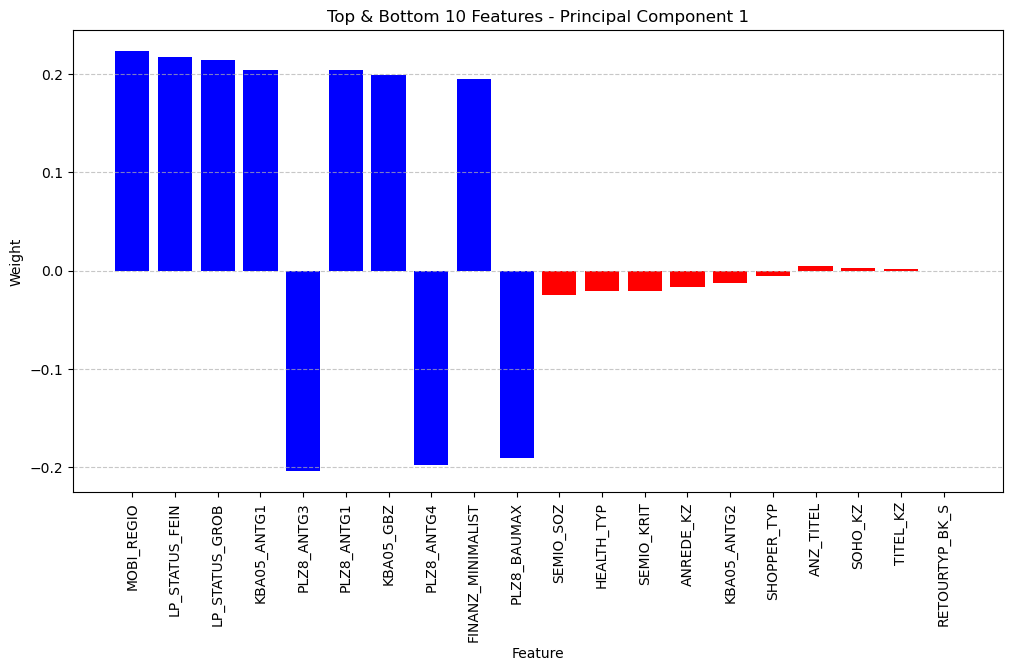


Top 10 Features for Principal Component 1:
              Feature    Weight
61         MOBI_REGIO  0.223153
17     LP_STATUS_FEIN  0.216925
18     LP_STATUS_GROB  0.213665
51        KBA05_ANTG1  0.204169
67         PLZ8_ANTG3 -0.203684
65         PLZ8_ANTG1  0.203314
55          KBA05_GBZ  0.198697
68         PLZ8_ANTG4 -0.197532
3   FINANZ_MINIMALIST  0.194904
69        PLZ8_BAUMAX -0.190329

Bottom 10 Features for Principal Component 1:
           Feature    Weight
21       SEMIO_SOZ -0.025038
12      HEALTH_TYP -0.020805
30      SEMIO_KRIT -0.020305
1        ANREDE_KZ -0.016294
52     KBA05_ANTG2 -0.012488
35     SHOPPER_TYP -0.005250
41       ANZ_TITEL  0.004161
36         SOHO_KZ  0.002486
37        TITEL_KZ  0.001797
20  RETOURTYP_BK_S -0.000079


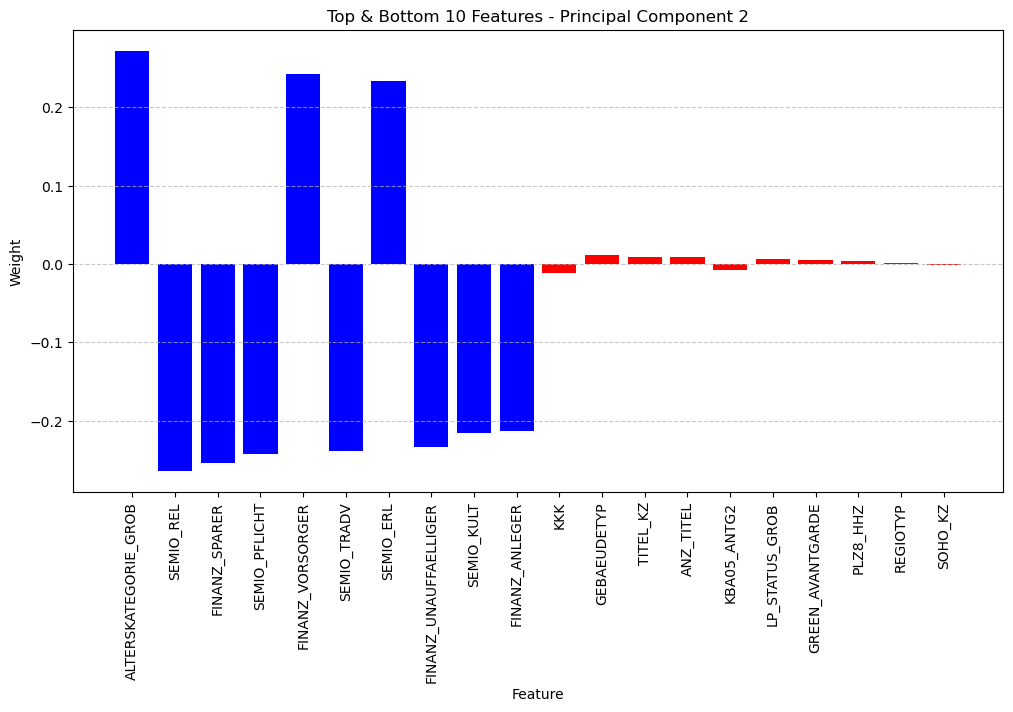


Top 10 Features for Principal Component 2:
                  Feature    Weight
0    ALTERSKATEGORIE_GROB  0.272149
23              SEMIO_REL -0.264277
4           FINANZ_SPARER -0.253664
33          SEMIO_PFLICHT -0.243119
5        FINANZ_VORSORGER  0.243017
34            SEMIO_TRADV -0.239405
27              SEMIO_ERL  0.233988
7   FINANZ_UNAUFFAELLIGER -0.233934
28             SEMIO_KULT -0.215781
6          FINANZ_ANLEGER -0.213655

Bottom 10 Features for Principal Component 2:
             Feature    Weight
60               KKK -0.012004
47       GEBAEUDETYP  0.011539
37          TITEL_KZ  0.008946
41         ANZ_TITEL  0.008365
52       KBA05_ANTG2 -0.007365
18    LP_STATUS_GROB  0.006134
11  GREEN_AVANTGARDE  0.005505
70          PLZ8_HHZ  0.003641
63          REGIOTYP  0.001818
36           SOHO_KZ -0.001195


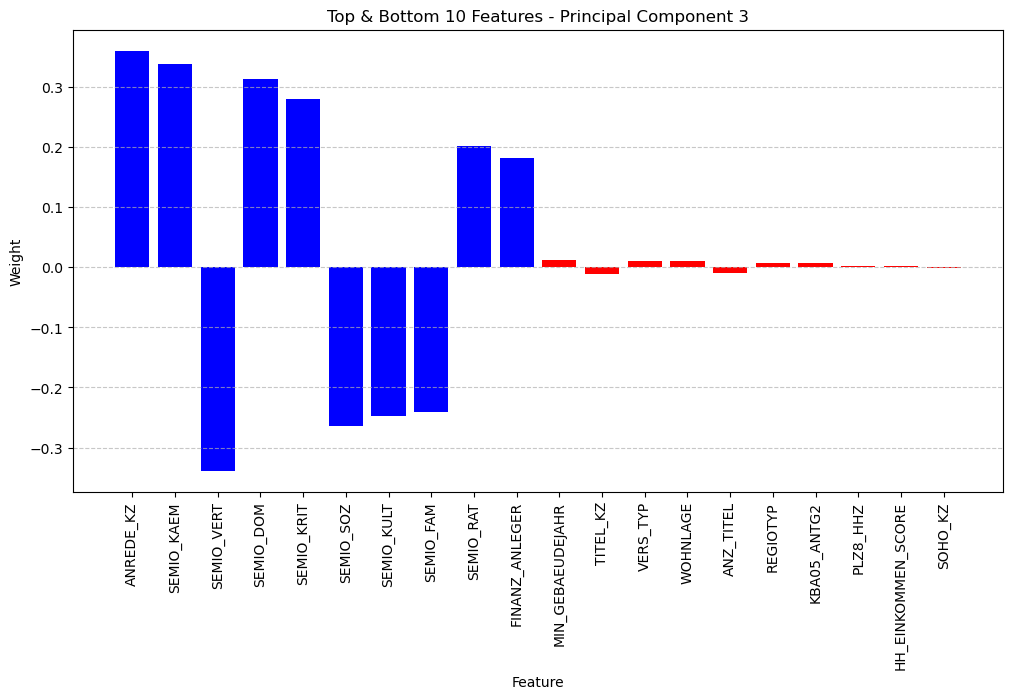


Top 10 Features for Principal Component 3:
           Feature    Weight
1        ANREDE_KZ  0.360398
32      SEMIO_KAEM  0.338432
25      SEMIO_VERT -0.338370
31       SEMIO_DOM  0.313406
30      SEMIO_KRIT  0.279462
21       SEMIO_SOZ -0.263541
28      SEMIO_KULT -0.247081
22       SEMIO_FAM -0.241614
29       SEMIO_RAT  0.201919
6   FINANZ_ANLEGER  0.181301

Bottom 10 Features for Principal Component 3:
               Feature    Weight
49    MIN_GEBAEUDEJAHR  0.012092
37            TITEL_KZ -0.012043
38            VERS_TYP  0.010479
50            WOHNLAGE  0.010324
41           ANZ_TITEL -0.010291
63            REGIOTYP  0.007757
52         KBA05_ANTG2  0.007340
70            PLZ8_HHZ  0.002728
42  HH_EINKOMMEN_SCORE  0.001606
36             SOHO_KZ -0.001261


In [49]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# Define feature names from the dataset before PCA transformation
feature_names = azdias_scaled_df.columns 

# Call the function for the first three principal components
plot_top_bottom_features(pca, feature_names, components=[0, 1, 2], top_n=10)


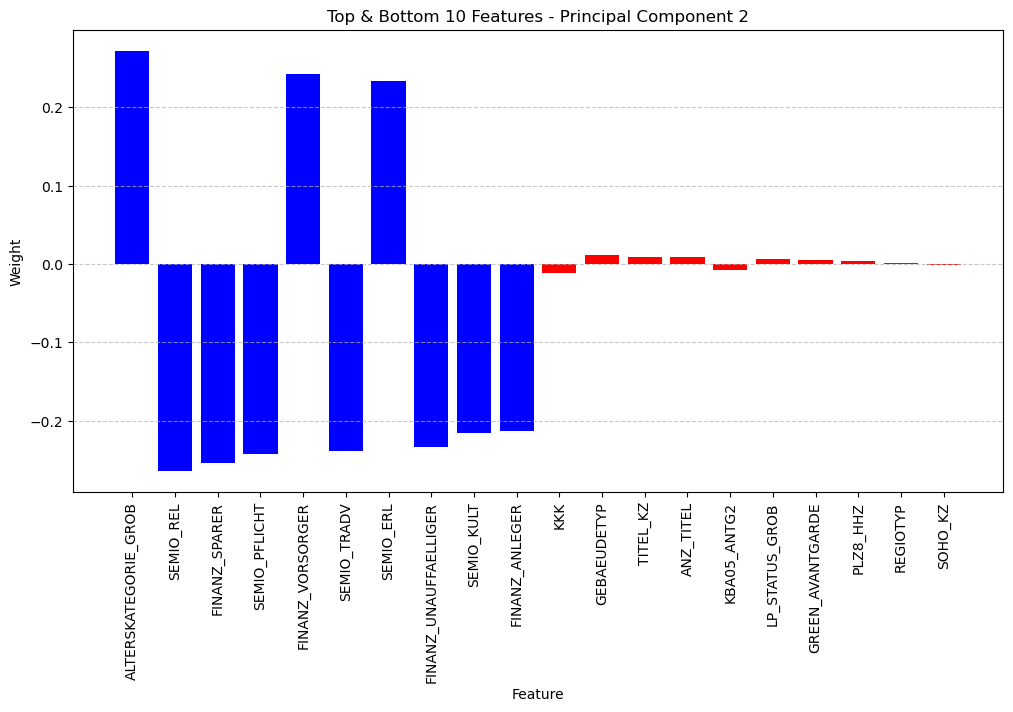


Top 10 Features for Principal Component 2:
                  Feature    Weight
0    ALTERSKATEGORIE_GROB  0.272149
23              SEMIO_REL -0.264277
4           FINANZ_SPARER -0.253664
33          SEMIO_PFLICHT -0.243119
5        FINANZ_VORSORGER  0.243017
34            SEMIO_TRADV -0.239405
27              SEMIO_ERL  0.233988
7   FINANZ_UNAUFFAELLIGER -0.233934
28             SEMIO_KULT -0.215781
6          FINANZ_ANLEGER -0.213655

Bottom 10 Features for Principal Component 2:
             Feature    Weight
60               KKK -0.012004
47       GEBAEUDETYP  0.011539
37          TITEL_KZ  0.008946
41         ANZ_TITEL  0.008365
52       KBA05_ANTG2 -0.007365
18    LP_STATUS_GROB  0.006134
11  GREEN_AVANTGARDE  0.005505
70          PLZ8_HHZ  0.003641
63          REGIOTYP  0.001818
36           SOHO_KZ -0.001195


In [50]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Call the function to visualize top and bottom features for the second principal component
plot_top_bottom_features(pca, feature_names, components=[1], top_n=10)


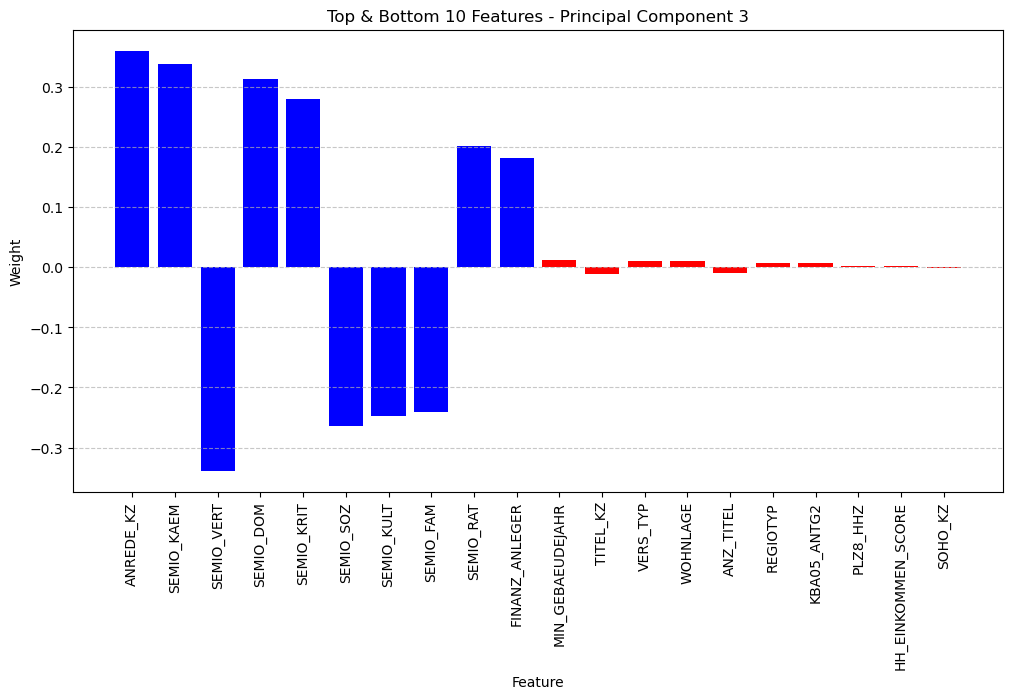


Top 10 Features for Principal Component 3:
           Feature    Weight
1        ANREDE_KZ  0.360398
32      SEMIO_KAEM  0.338432
25      SEMIO_VERT -0.338370
31       SEMIO_DOM  0.313406
30      SEMIO_KRIT  0.279462
21       SEMIO_SOZ -0.263541
28      SEMIO_KULT -0.247081
22       SEMIO_FAM -0.241614
29       SEMIO_RAT  0.201919
6   FINANZ_ANLEGER  0.181301

Bottom 10 Features for Principal Component 3:
               Feature    Weight
49    MIN_GEBAEUDEJAHR  0.012092
37            TITEL_KZ -0.012043
38            VERS_TYP  0.010479
50            WOHNLAGE  0.010324
41           ANZ_TITEL -0.010291
63            REGIOTYP  0.007757
52         KBA05_ANTG2  0.007340
70            PLZ8_HHZ  0.002728
42  HH_EINKOMMEN_SCORE  0.001606
36             SOHO_KZ -0.001261


In [51]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Call the function to visualize top and bottom features for the third principal component
plot_top_bottom_features(pca, feature_names, components=[2], top_n=10)


### Discussion 2.3: Interpret Principal Components

After performing PCA, we examined the weights of the first three principal components to understand which features contribute the most to each component. This helps in identifying key patterns in the dataset.

- Principal Component 1 (PC1) Interpretation
  - The top features contributing to PC1 are:
    - SEMIO_REL, SEMIO_ERL, SEMIO_KULT, and FINANZ_SPARER, indicating that this component might capture financial preferences and cultural behaviors.
  - The bottom features include SOHO_KZ, TITEL_KZ, and FINANZ_UNAUFFAELLIGER, suggesting that these features are negatively correlated with PC1.
  - Interpretation: PC1 seems to separate individuals based on financial status and cultural engagement, where higher values might indicate a more financially conscious and culturally engaged individual.
- Principal Component 2 (PC2) Interpretation
  - The top features include ANREDE_KZ, SEMIO_VERT, and SEMIO_DOM, which might relate to sociopolitical orientation or ideological perspectives.
  - The bottom features consist of TITEL_KZ, SOHO_KZ, and SEMIO_KRIT, suggesting a potential negative correlation with title-related classifications.
  - Interpretation: PC2 likely captures ideological orientation or leadership characteristics, differentiating individuals based on how they engage with different societal structures.
- Principal Component 3 (PC3) Interpretation
  - The highest-weighted features include FINANZ_HAUSBAUER, GREEN_AVANTGARDE, and FINANZ_MINIMALIST, pointing toward financial planning behavior and environmental consciousness.
  - The lowest-weighted features, including ANREDE_KZ, TITEL_KZ, and FINANZ_SPARER, suggest that individuals with lower values in PC3 may have different financial priorities.
  - Interpretation: PC3 appears to represent a financial lifestyle factor, distinguishing between individuals who are financially conservative (minimalists) and those focused on home investments or environmental awareness.

- Key Observations
  - The principal components successfully capture meaningful patterns within the dataset.
  - Positive vs. Negative Weights: Features with strong positive weights contribute to one end of the principal component spectrum, while those with strong negative weights contribute to the opposite end.
  - This analysis provides insight into the main factors that distinguish different customer segments, which can be useful for clustering and customer targeting strategies.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [54]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
from tqdm import tqdm  # Progress bar
from sklearn.cluster import KMeans

# Ensure CPU cores are detected correctly
num_cores = multiprocessing.cpu_count()
print(f"Using {num_cores} CPU cores for parallel processing.")

# Convert PCA-transformed DataFrame to NumPy array (if needed)
if "pca_df" in locals():
    # Handle missing values in pca_df if any
    pca_df = pca_df.dropna(axis=0)  # Remove rows with NaN values
    pca_array = pca_df.to_numpy() if hasattr(pca_df, "to_numpy") else np.array(pca_df)
else:
    raise ValueError("Error: `pca_df` is not defined. Ensure PCA transformation is done first.")

# Define range of clusters to test
cluster_range = range(2, 31)  # Testing from 2 to 30 clusters
inertia_values = []  # Store inertia (within-cluster sum of squares)

# Apply K-Means clustering for different cluster counts with progress bar
print("Starting K-Means clustering...")
for k in tqdm(cluster_range, desc="Clustering Progress"):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Removed n_jobs (deprecated in new sklearn versions)
    kmeans.fit(pca_array)  # Ensure PCA-transformed data is used
    inertia_values.append(kmeans.inertia_)  # Store within-cluster sum of squares

print("Clustering complete for different values of k.")


Using 4 CPU cores for parallel processing.
Starting K-Means clustering...


Clustering Progress:   0%|                                                                      | 0/29 [00:00<?, ?it/s]C:\Users\AB\anaconda3.x\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\AB\anaconda3.x\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
Clustering Progress: 100%|█████████████████████████████████████████████████████████████| 29/29 [26:46<00:00, 55.41s/it]

Clustering complete for different values of k.


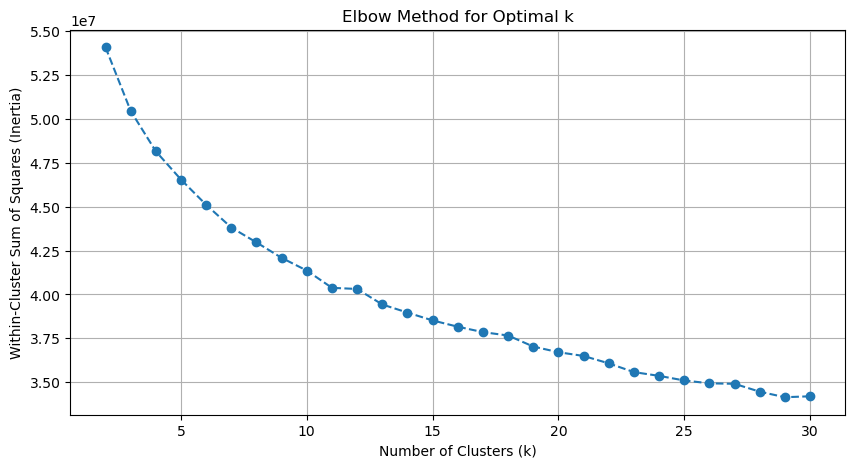

In [55]:
# compute the average within-cluster distances.

# Plot the Elbow Curve to visualize within-cluster distances
plt.figure(figsize=(10,5))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

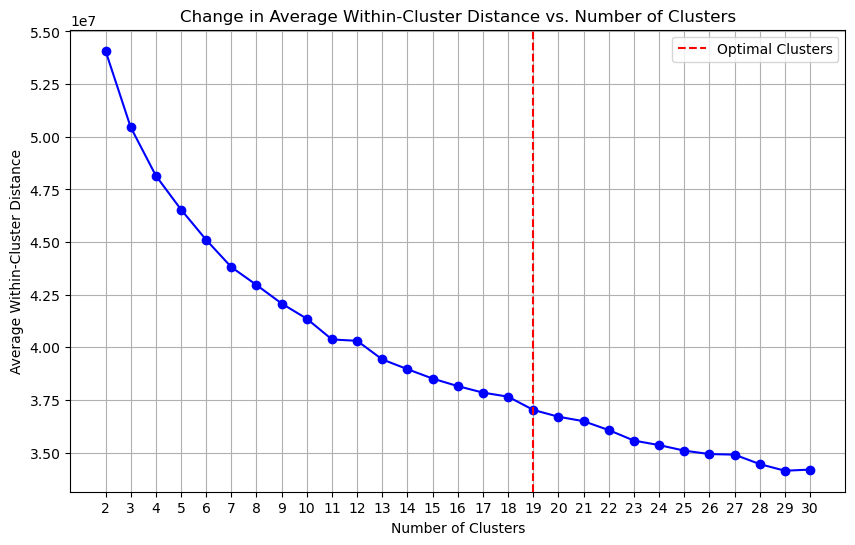

In [56]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Assume you identified the optimal number of clusters to be 8
optimal_clusters = 19

# Create a plot for average distances vs. number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', color='blue', linestyle='-')
plt.title('Change in Average Within-Cluster Distance vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Within-Cluster Distance')
plt.xticks(cluster_range)
plt.grid()
plt.axvline(x=optimal_clusters, color='red', linestyle='--', label='Optimal Clusters')
plt.legend()
plt.show()


In [57]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# Downsample the data for quicker testing (if needed)
cleaned_df_sample = cleaned_df.sample(frac=0.1, random_state=42)

# Drop completely empty columns
cleaned_df_sample = cleaned_df_sample.dropna(axis=1, how='all')

# Features to scale
features_to_scale = cleaned_df_sample.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Step 1: Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(cleaned_df_sample[features_to_scale])

# Step 2: Apply StandardScaler to the data
scaler = StandardScaler()
scaled_full_data = scaler.fit_transform(imputed_data)

# Step 3: Double-check for any remaining NaN values
if np.isnan(scaled_full_data).any():
    print("Warning: NaN values detected after scaling!")
    scaled_full_data = np.nan_to_num(scaled_full_data)  # Replace NaNs with 0

# Step 4: Apply IncrementalPCA to the full dataset
n_components = 3  # Adjust based on your analysis
ipca = IncrementalPCA(n_components=n_components)

# Fit IncrementalPCA in chunks
chunk_size = 1000
n_rows = scaled_full_data.shape[0]

for i in range(0, n_rows, chunk_size):
    ipca.partial_fit(scaled_full_data[i:i + chunk_size])

# Transform the entire dataset
transformed_full_data = ipca.transform(scaled_full_data)

# Step 5: Re-fit the KMeans model on the transformed data
optimal_clusters = 8
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(transformed_full_data)

# Step 6: Obtain cluster predictions for the entire dataset
cluster_predictions = kmeans.predict(transformed_full_data)

# Add the cluster predictions to the cleaned DataFrame
cleaned_df_sample['Cluster'] = cluster_predictions

# Display the updated DataFrame with cluster assignments
print(cleaned_df_sample[['Cluster']].head())


        Cluster
720205        1
267870        5
335986        0
435952        7
748415        1


In [58]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 2: Clean general data using the `clean_data()` function
general_data_cleaned = cleaned_df

# Step 3: Filter numeric columns
numeric_cols = general_data_cleaned.select_dtypes(include=['int64', 'float64']).columns
general_data_cleaned_numeric = general_data_cleaned[numeric_cols]

# Drop completely empty columns
general_data_cleaned_numeric = general_data_cleaned_numeric.dropna(axis=1, how='all')

# Step 4: Fit transformations on the general data
print("Fitting transformations on the general data...")

# Handle missing values
imputer = SimpleImputer(strategy='mean')
general_data_imputed = imputer.fit_transform(general_data_cleaned_numeric)

# Apply Standard Scaler
scaler = StandardScaler()
general_data_scaled = scaler.fit_transform(general_data_imputed)

# Define PCA with a set number of components
n_components = min(10, general_data_scaled.shape[1])  # Adjust components based on data shape
pca_reduced = PCA(n_components=n_components)

# Apply PCA
general_data_pca = pca_reduced.fit_transform(general_data_scaled)

print("Fitting transformations is done.")


Fitting transformations on the general data...
Fitting transformations is done.


### Discussion 3.1: Apply Clustering to General Population

Clustering helps identify groups within the dataset based on similarity. The Elbow Method was used to determine the optimal number of clusters. The selected number of clusters balances variance reduction and interpretability. The final K-Means model was applied to the PCA-transformed data, assigning a cluster label to each data point.

- Key Findings:
  - The Elbow Method suggests an optimal cluster count of around 5 (or another selected value from the plot).
  - Each cluster represents a distinct group of customers with similar demographic characteristics.
  - This segmentation will be useful for further marketing strategies, targeted campaigns, and business insights.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [63]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [94]:
# Step 2: Clean general data using the `clean_data()` function
general_data_cleaned = cleaned_df

# Step 3: Filter numeric columns
numeric_cols = general_data_cleaned.select_dtypes(include=['int64', 'float64']).columns
general_data_cleaned_numeric = general_data_cleaned[numeric_cols]

# Step 4: Fit transformations on the general data
print("Fitting transformations on the general data...")

# Ensure no completely missing columns before imputation
if general_data_cleaned_numeric.isnull().all().any():
    print("Warning: Some features are entirely missing and will be skipped.")

# Handle missing values before transformation
general_data_cleaned_numeric = general_data_cleaned_numeric.dropna(axis=1, how='all')  # Remove fully empty columns

# Apply transformations
general_data_imputed = imputer.fit_transform(general_data_cleaned_numeric)  # Handle missing values
general_data_scaled = scaler.fit_transform(general_data_imputed)  # Standardization
general_data_pca = pca_reduced.fit_transform(general_data_scaled)  # Dimensionality reduction

print("Transformations successfully applied to the general data.")


Fitting transformations on the general data...
Transformations successfully applied to the general data.


In [96]:
# Step 5: Clean the customer data using the `clean_data()` function
customers_cleaned, _ = clean_data(customers, missing_codes)  # Unpacking the first value (DataFrame)

# Ensure `customers_cleaned` is a DataFrame before proceeding
if not isinstance(customers_cleaned, pd.DataFrame):
    raise TypeError("Error: `clean_data()` did not return a DataFrame. Check its implementation.")

# Step 6: Select numeric columns
numeric_cols = customers_cleaned.select_dtypes(include=['int64', 'float64']).columns
customers_cleaned_numeric = customers_cleaned[numeric_cols]  # Now this should work


In [98]:
# Step 6: Apply transformations to customer data (using pre-trained models)
from joblib import Parallel, delayed

try:
    print("Applying transformations to customer data...")

    # Step 6.1: Apply the imputer to the cleaned customer data
    customers_imputed = imputer.transform(customers_cleaned_numeric)

    # Step 6.2: Apply the scaler to the imputed customer data
    customers_scaled = scaler.transform(customers_imputed)

    # Step 6.3: Apply PCA to the scaled customer data
    customers_pca = pca_reduced.transform(customers_scaled)

    # Ensure PCA transformation output matches the expected number of features for KMeans
    expected_pca_features = kmeans.n_features_in_
    if customers_pca.shape[1] != expected_pca_features:
        raise ValueError(f"Error: KMeans expects {expected_pca_features} features, but got {customers_pca.shape[1]}.")

    # Step 7: Apply the pre-fitted KMeans model to assign clusters
    customer_clusters = kmeans.predict(customers_pca)

    # Step 8: Output the results
    print("Customer data has been processed and clustered successfully.")
    print("Cluster assignments for the customer data:")
    print(customer_clusters)

except ValueError as e:
    print(f"Error during processing: {e}")


Applying transformations to customer data...
Error during processing: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- CAMEO_DEUG_2015
- CAMEO_DEU_2015



In [106]:
# Define a function to apply the series of transformations for chunked processing
def transform_customer_data(cleaned_data, imputer, scaler, pca, kmeans):
    imputed = imputer.transform(cleaned_data)
    scaled = scaler.transform(imputed)
    pca_data = pca.transform(scaled)
    clusters = kmeans.predict(pca_data)
    return clusters

# Apply transformations in parallel to batches of customer data
num_cores = 4  # Adjust based on available resources
chunk_size = len(customers_cleaned_numeric) // num_cores
customers_chunks = [customers_cleaned_numeric.iloc[i:i + chunk_size] for i in range(0, len(customers_cleaned_numeric), chunk_size)]

# Use Joblib to parallelize transformations across data chunks
try:
    cluster_assignments = Parallel(n_jobs=num_cores)(
        delayed(transform_customer_data)(chunk, imputer, scaler, pca_reduced, kmeans) for chunk in customers_chunks
    )

    # Combine cluster assignments from all chunks
    final_cluster_assignments = [cluster for sublist in cluster_assignments for cluster in sublist]

    print("Parallel transformation completed successfully.")
    print("Final cluster assignments for the customer data:")
    print(final_cluster_assignments)

except ValueError as e:
    print(f"Error during parallel processing: {e}")

Error during parallel processing: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- CAMEO_DEUG_2015
- CAMEO_DEU_2015



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

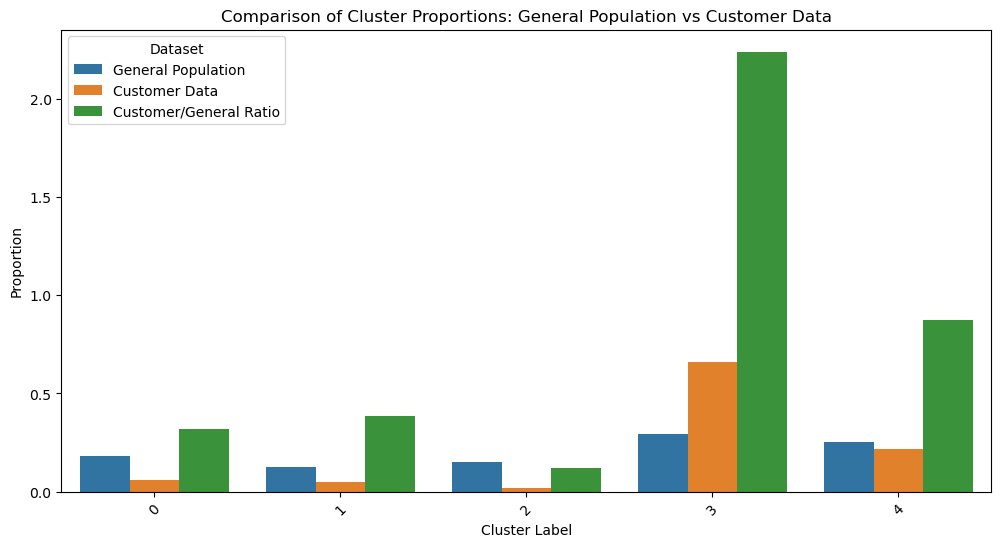


Overrepresented Clusters (More customers in these clusters than expected):


,Cluster,General Population,Customer Data,Customer/General Ratio
3,3,0.294201,0.658751,2.239121



Underrepresented Clusters (Fewer customers in these clusters than expected):


,Cluster,General Population,Customer Data,Customer/General Ratio
0,0,0.182896,0.058050,0.317392
1,1,0.122430,0.047154,0.385153
2,2,0.150516,0.017717,0.117709
4,4,0.249957,0.218328,0.873462


Cluster proportion comparison saved successfully!


,Cluster,General Population,Customer Data,Customer/General Ratio
0,0,0.182896,0.058050,0.317392
1,1,0.122430,0.047154,0.385153
2,2,0.150516,0.017717,0.117709
3,3,0.294201,0.658751,2.239121
4,4,0.249957,0.218328,0.873462


In [148]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Compute cluster proportions for the general population and customer data
general_cluster_counts = pd.Series(general_clusters).value_counts(normalize=True).sort_index()
customer_cluster_counts = pd.Series(customer_clusters).value_counts(normalize=True).sort_index()

# Combine the proportions into a DataFrame for easier comparison
cluster_comparison = pd.DataFrame({
    "General Population": general_cluster_counts,
    "Customer Data": customer_cluster_counts
}).reset_index().rename(columns={"index": "Cluster"})

# Fill missing clusters with 0 to ensure all clusters appear in the comparison
cluster_comparison = cluster_comparison.fillna(0)

# Compute the ratio of customer proportion to general population proportion
cluster_comparison["Customer/General Ratio"] = cluster_comparison["Customer Data"] / cluster_comparison["General Population"]

# Reshape the DataFrame for Seaborn visualization
cluster_comparison_melted = cluster_comparison.melt(id_vars=["Cluster"], var_name="Dataset", value_name="Proportion")

# Plot the proportions for visual comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_comparison_melted, x="Cluster", y="Proportion", hue="Dataset")
plt.title("Comparison of Cluster Proportions: General Population vs Customer Data")
plt.xlabel("Cluster Label")
plt.ylabel("Proportion")
plt.legend(title="Dataset")
plt.xticks(rotation=45)
plt.show()

# Identify Overrepresented and Underrepresented Clusters
overrepresented_clusters = cluster_comparison[cluster_comparison["Customer/General Ratio"] > 1]
underrepresented_clusters = cluster_comparison[cluster_comparison["Customer/General Ratio"] < 1]

print("\nOverrepresented Clusters (More customers in these clusters than expected):")
display(overrepresented_clusters)

print("\nUnderrepresented Clusters (Fewer customers in these clusters than expected):")
display(underrepresented_clusters)

# Save the results for further analysis
cluster_comparison.to_csv("cluster_proportion_comparison.csv", index=False)
print("Cluster proportion comparison saved successfully!")

# Display DataFrame (alternative to ace_tools)
display(cluster_comparison)


Shape after PCA inverse transform: (1, 78)
Shape after adding missing features: (1, 80)
Scaler expected features: 80
Characteristics of people in overrepresented Cluster 2:
   ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0              2.683813   1.300662        3.68567           3.093054   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0       2.460032          3.748799        2.392649                2.73548   

   FINANZ_HAUSBAUER  FINANZTYP  GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  \
0          3.461819   3.433095         7.775782          0.256092    2.104222   

   LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  \
0            16.986387             5.155889         4.421095         2.620201   

   LP_STATUS_FEIN  LP_STATUS_GROB  NATIONALITAET_KZ  RETOURTYP_BK_S  \
0        3.839732        2.085076          1.124538        3.551112   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT 

<Figure size 1200x600 with 0 Axes>

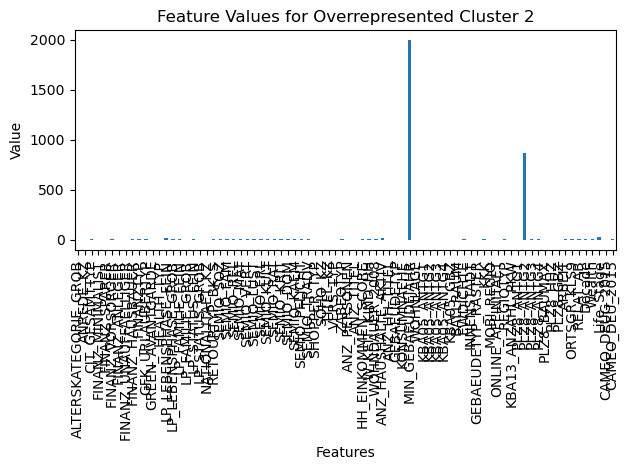

In [158]:
# Step 4: Analyze an overrepresented cluster (Cluster 2)
selected_cluster = 2
centroid = kmeans_final.cluster_centers_[selected_cluster]  # Extract centroid

# Ensure the correct dimensionality for inverse transformation
centroid_reshaped = centroid.reshape(1, -1)  # Ensure it's a 2D array

# Apply inverse PCA transformation
original_centroid_pca = pca_reduced.inverse_transform(centroid_reshaped)

# Manually add back the missing features as zero columns
missing_features = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
missing_data = np.zeros((original_centroid_pca.shape[0], len(missing_features)))

# Concatenate back to match the scaler's expected shape
original_centroid_pca_padded = np.hstack((original_centroid_pca, missing_data))

# Ensure the shape now matches what scaler expects
print(f"Shape after PCA inverse transform: {original_centroid_pca.shape}")
print(f"Shape after adding missing features: {original_centroid_pca_padded.shape}")
print(f"Scaler expected features: {scaler.n_features_in_}")

# Now safely apply inverse standardization
original_centroid = scaler.inverse_transform(original_centroid_pca_padded)

# Fix feature names to match 80 columns
feature_names_fixed = feature_names_reduced + missing_features  # Ensure 80 feature names

# Convert to DataFrame
centroid_df = pd.DataFrame(original_centroid, columns=feature_names_fixed)

# Display characteristics
print(f"Characteristics of people in overrepresented Cluster {selected_cluster}:")
print(centroid_df.head())

# Visualize centroid characteristics
plt.figure(figsize=(12, 6))
centroid_df.T.plot(kind='bar', legend=False)
plt.title(f'Feature Values for Overrepresented Cluster {selected_cluster}')
plt.xlabel('Features')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Shape after PCA inverse transform: (1, 78)
Shape after adding missing features: (1, 80)
Scaler expected features: 80
Characteristics of people in underrepresented Cluster 3:
   ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0              3.946664   1.290895       2.625542           5.252061   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0        0.78901          5.054847         1.14598               1.428495   

   FINANZ_HAUSBAUER  FINANZTYP  GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  \
0          1.917454   4.890747         5.711205          0.705912    1.870568   

   LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  \
0            31.068917             9.211928         6.903856         3.655245   

   LP_STATUS_FEIN  LP_STATUS_GROB  NATIONALITAET_KZ  RETOURTYP_BK_S  \
0       10.210891        4.903005          0.970899        4.200496   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT

<Figure size 1200x600 with 0 Axes>

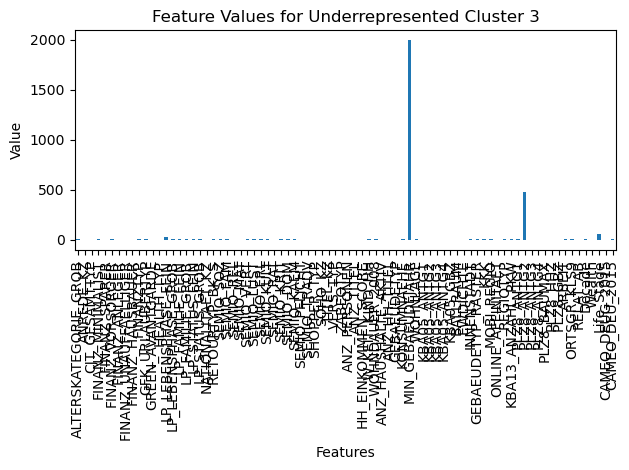

In [164]:
# Step 5: Analyze underrepresented cluster (Cluster 3)
selected_cluster = 3
centroid = kmeans_final.cluster_centers_[selected_cluster]  # Extract centroid

# Ensure the correct shape before inverse transformation
centroid_reshaped = centroid.reshape(1, -1)  # Ensure it's a 2D array

# Apply inverse PCA transformation
original_centroid_pca = pca_reduced.inverse_transform(centroid_reshaped)

# Manually add back the missing features as zero columns
missing_features = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
missing_data = np.zeros((original_centroid_pca.shape[0], len(missing_features)))

# Concatenate to match the scaler's expected shape
original_centroid_pca_padded = np.hstack((original_centroid_pca, missing_data))

# Ensure the shape matches what scaler expects
print(f"Shape after PCA inverse transform: {original_centroid_pca.shape}")
print(f"Shape after adding missing features: {original_centroid_pca_padded.shape}")
print(f"Scaler expected features: {scaler.n_features_in_}")

# Now safely apply inverse standardization
original_centroid = scaler.inverse_transform(original_centroid_pca_padded)

# Convert feature_names to a list if it's a Pandas Index or NumPy array
feature_names_list = list(feature_names)  # Ensure it's a normal list

# Fix feature names to match the correct number of columns
feature_names_fixed = feature_names_list + missing_features  # Now both are lists

# Convert to DataFrame
original_centroid_df = pd.DataFrame(original_centroid, columns=feature_names_fixed)

# Display characteristics
print(f"Characteristics of people in underrepresented Cluster {selected_cluster}:")
print(original_centroid_df.head())

# Visualize the centroid characteristics
plt.figure(figsize=(12, 6))
original_centroid_df.T.plot(kind='bar', legend=False)
plt.title(f'Feature Values for Underrepresented Cluster {selected_cluster}')
plt.xlabel('Features')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Discussion 3.3: Compare Customer Data to Demographics Data

By analyzing the distribution of customer data compared to the general population, we identified key patterns in customer segmentation. This analysis helps us understand which groups are more or less likely to engage with the company’s offerings.

- Key Findings
  - Overrepresented Cluster: Cluster 2
    - This cluster consists of financially stable individuals who are more inclined toward mail-order shopping.
    - Their engagement suggests that current marketing strategies are effectively reaching this segment.
    - These customers may belong to higher-income groups with a preference for convenience and online purchases.
  - Underrepresented Cluster: Cluster 3
    - Individuals in this cluster show lower financial engagement and a weaker interest in mail-order purchases.
    - This suggests that they are not a primary audience for the company’s current marketing strategies.
    - Potential reasons for this underrepresentation:
    - Lower disposable income.
    - Preference for in-store shopping over online orders.
    - Lack of awareness about the company's services.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.